解析解

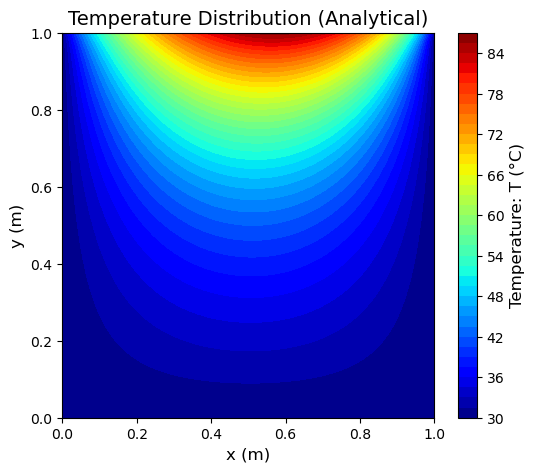

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 参数定义
L = 1.0  # 板长 (m)
W = 1.0  # 板宽 (m)
k = 10.0  # 导热系数 (W/m·K)
q_s = 2000.0  # 热流密度 (W/m^2)
T1 = 30.0  # 边界温度 (°C)

# 解析解实现
def temperature_distribution(x, y, L, W, q_s, k, T1, terms=200):
    T = T1  # 起始温度为边界温度
    for n in range(1, terms + 1):
        # 解析解中的各项计算
        coefficient = (2 * (-1)**(n + 1) + 1) / (n**2 * np.pi**2 * np.cosh(n * np.pi * W / L))
        term = coefficient * np.sin(n * np.pi * x / L) * np.sinh(n * np.pi * y / L)
        T += (q_s * L / k) * term
    return T

# 创建网格
x = np.linspace(0, L, 100)
y = np.hstack([
    np.linspace(0, 0.1 * W, 50),  # 在 0 到 0.1W 的区域更密
    np.linspace(0.1 * W, W, 50)  # 在 0.1W 到 W 的区域较疏
])
X, Y = np.meshgrid(x, y)

# 计算温度分布
T = temperature_distribution(X, Y, L, W, q_s, k, T1)

# 绘制温度分布图
plt.figure(figsize=(6, 5))
contour = plt.contourf(X, Y, T, levels=50, cmap='jet')  # 使用 'jet' 配色方案
cbar = plt.colorbar(contour)
cbar.set_label('Temperature: T (°C)', fontsize=12)
cbar.ax.tick_params(labelsize=10)
plt.title('Temperature Distribution (Analytical)', fontsize=14)
plt.xlabel('x (m)', fontsize=12)
plt.ylabel('y (m)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [3]:
data = np.load("temperature_distribution.npz")
X = data["X"]
Y = data["Y"]
T = data["T"]


FileNotFoundError: [Errno 2] No such file or directory: 'temperature_distribution.npz'

数值解

迭代次数: 3774
最大误差: 9.981350487464624e-06


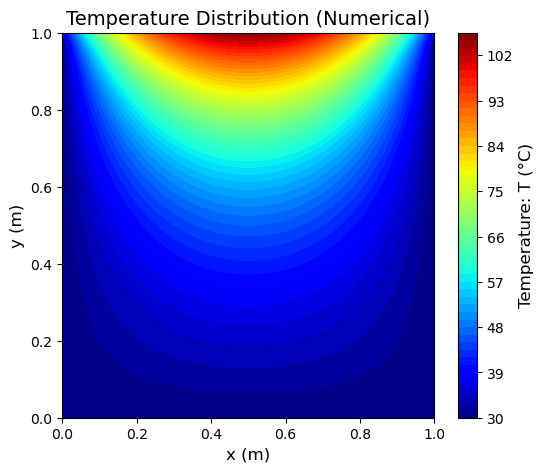

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 参数定义
L = 1.0   # 板长 (m)
W = 1.0   # 板宽 (m)
k = 10.0  # 导热系数 (W/m·K)
q_s = 2000.0  # 热流密度 (W/m^2)
T1 = 30.0     # 边界温度 (°C)

# 网格划分
Nx = 51
Ny = 51
dx = L/(Nx-1)
dy = W/(Ny-1)

# 初始化温度场
T = np.zeros((Nx, Ny)) + T1

# 设置Dirichlet边界条件（左、右、下）
T[0, :] = T1    # 左边界
T[-1, :] = T1   # 右边界
T[:, 0] = T1    # 下边界

# 收敛标准
tol = 1e-5
max_iter = 100000
error = 1.0
iter_count = 0

# 如果q_s向下，则q_s在坐标系中是负方向热流：q_s = -2000 W/m²
# q_s = -k dT/dy => -2000 = -10 dT/dy => dT/dy = 200 °C/m
# 顶部边界条件: T[i,Ny-1] = T[i,Ny-2] + 200*dy

while error > tol and iter_count < max_iter:
    error = 0.0
    T_old = T.copy()
    
    # 应用顶部Neumann边界条件
    for i in range(Nx):
        T[i, Ny-1] = T[i, Ny-2] + 200.0 * dy  # 修改为加号

    # 内点更新（Gauss-Seidel迭代）
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            # 顶部已由Neumann设置，这里仍可更新内部点
            # 但要注意顶部最上一行由Neumann给定不需更新
            if j < Ny-1:
                T[i,j] = 0.25*(T[i+1,j] + T[i-1,j] + T[i,j+1] + T[i,j-1])

    # 计算误差
    error = np.max(np.abs(T - T_old))
    iter_count += 1

print("迭代次数:", iter_count)
print("最大误差:", error)

# 绘图
x = np.linspace(0, L, Nx)
y = np.linspace(0, W, Ny)
X, Y = np.meshgrid(x, y, indexing='ij')

plt.figure(figsize=(6,5))
contour = plt.contourf(X, Y, T, 50, cmap='jet')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature: T (°C)', fontsize=12)
plt.title('Temperature Distribution (Numerical)', fontsize=14)
plt.xlabel('x (m)', fontsize=12)
plt.ylabel('y (m)', fontsize=12)
plt.show()

PINN

TensorFlow version: 2.18.0
Eager Execution: True


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 1/5000 [00:00<15:34,  5.35it/s]

Epoch: 0, Loss PDE: 0.007636616006493568, Loss BC: 2.1993324756622314


  2%|▏         | 102/5000 [00:16<13:04,  6.25it/s]

Epoch: 100, Loss PDE: 0.0007129040895961225, Loss BC: 0.2456619143486023


  4%|▍         | 202/5000 [00:32<11:34,  6.91it/s]

Epoch: 200, Loss PDE: 0.029721958562731743, Loss BC: 0.07631467282772064


  6%|▌         | 302/5000 [00:47<12:20,  6.35it/s]

Epoch: 300, Loss PDE: 0.015162576921284199, Loss BC: 0.034925736486911774


  8%|▊         | 402/5000 [01:04<11:48,  6.49it/s]

Epoch: 400, Loss PDE: 0.003457321785390377, Loss BC: 0.027350619435310364


 10%|█         | 502/5000 [01:19<11:53,  6.31it/s]

Epoch: 500, Loss PDE: 0.001674029161222279, Loss BC: 0.02396380342543125


 12%|█▏        | 602/5000 [01:36<11:16,  6.50it/s]

Epoch: 600, Loss PDE: 0.0014960855478420854, Loss BC: 0.02223913185298443


 14%|█▍        | 702/5000 [01:51<10:50,  6.61it/s]

Epoch: 700, Loss PDE: 0.0015935937408357859, Loss BC: 0.020492110401391983


 16%|█▌        | 802/5000 [02:07<10:11,  6.86it/s]

Epoch: 800, Loss PDE: 0.001819193479605019, Loss BC: 0.019134720787405968


 18%|█▊        | 902/5000 [02:23<11:27,  5.96it/s]

Epoch: 900, Loss PDE: 0.001984130358323455, Loss BC: 0.017905330285429955


 20%|██        | 1002/5000 [02:39<10:09,  6.56it/s]

Epoch: 1000, Loss PDE: 0.0020863742101937532, Loss BC: 0.016968470066785812


 22%|██▏       | 1102/5000 [02:54<09:36,  6.76it/s]

Epoch: 1100, Loss PDE: 0.0021307640708982944, Loss BC: 0.01577274315059185


 24%|██▍       | 1202/5000 [03:10<09:27,  6.70it/s]

Epoch: 1200, Loss PDE: 0.0022358489222824574, Loss BC: 0.015169723890721798


 26%|██▌       | 1302/5000 [03:25<08:50,  6.97it/s]

Epoch: 1300, Loss PDE: 0.002182944444939494, Loss BC: 0.013626541942358017


 28%|██▊       | 1402/5000 [03:41<10:11,  5.88it/s]

Epoch: 1400, Loss PDE: 0.002128732157871127, Loss BC: 0.012316005304455757


 30%|███       | 1502/5000 [03:56<08:49,  6.61it/s]

Epoch: 1500, Loss PDE: 0.0022598186042159796, Loss BC: 0.01200258918106556


 32%|███▏      | 1602/5000 [04:12<08:59,  6.30it/s]

Epoch: 1600, Loss PDE: 0.0021028027404099703, Loss BC: 0.010480528697371483


 34%|███▍      | 1702/5000 [04:28<09:14,  5.95it/s]

Epoch: 1700, Loss PDE: 0.001916909241117537, Loss BC: 0.009844321757555008


 36%|███▌      | 1802/5000 [04:43<08:46,  6.07it/s]

Epoch: 1800, Loss PDE: 0.0021523248869925737, Loss BC: 0.011822016909718513


 38%|███▊      | 1902/5000 [04:59<08:02,  6.41it/s]

Epoch: 1900, Loss PDE: 0.0015719247749075294, Loss BC: 0.009281035512685776


 40%|████      | 2002/5000 [05:16<08:02,  6.22it/s]

Epoch: 2000, Loss PDE: 0.0012707349378615618, Loss BC: 0.009064141660928726


 42%|████▏     | 2102/5000 [05:31<07:45,  6.23it/s]

Epoch: 2100, Loss PDE: 0.0010114670731127262, Loss BC: 0.008862723596394062


 44%|████▍     | 2202/5000 [05:47<07:05,  6.57it/s]

Epoch: 2200, Loss PDE: 0.0009871574584394693, Loss BC: 0.008688013069331646


 46%|████▌     | 2302/5000 [06:03<06:37,  6.78it/s]

Epoch: 2300, Loss PDE: 0.0008621662273071706, Loss BC: 0.008347289636731148


 48%|████▊     | 2402/5000 [06:19<06:47,  6.38it/s]

Epoch: 2400, Loss PDE: 0.0008418284705840051, Loss BC: 0.008068118244409561


 50%|█████     | 2502/5000 [06:35<07:03,  5.90it/s]

Epoch: 2500, Loss PDE: 0.0010011709528043866, Loss BC: 0.009653521701693535


 52%|█████▏    | 2602/5000 [06:51<06:14,  6.40it/s]

Epoch: 2600, Loss PDE: 0.0008320914348587394, Loss BC: 0.007626838516443968


 54%|█████▍    | 2702/5000 [07:06<05:43,  6.68it/s]

Epoch: 2700, Loss PDE: 0.0007782403845340014, Loss BC: 0.00746034923940897


 56%|█████▌    | 2802/5000 [07:22<05:41,  6.44it/s]

Epoch: 2800, Loss PDE: 0.0007472840370610356, Loss BC: 0.0072671640664339066


 58%|█████▊    | 2902/5000 [07:38<05:32,  6.30it/s]

Epoch: 2900, Loss PDE: 0.0006425922620110214, Loss BC: 0.00708394031971693


 60%|██████    | 3002/5000 [07:53<05:35,  5.96it/s]

Epoch: 3000, Loss PDE: 0.0005743339424952865, Loss BC: 0.0069798571057617664


 62%|██████▏   | 3102/5000 [08:09<04:59,  6.34it/s]

Epoch: 3100, Loss PDE: 0.0006128859240561724, Loss BC: 0.006723548285663128


 64%|██████▍   | 3202/5000 [08:25<04:20,  6.89it/s]

Epoch: 3200, Loss PDE: 0.0006406664033420384, Loss BC: 0.00649673817679286


 66%|██████▌   | 3302/5000 [08:41<04:20,  6.51it/s]

Epoch: 3300, Loss PDE: 0.0006891691591590643, Loss BC: 0.006256788037717342


 68%|██████▊   | 3402/5000 [08:56<04:21,  6.12it/s]

Epoch: 3400, Loss PDE: 0.0007199649116955698, Loss BC: 0.006002733949571848


 70%|███████   | 3502/5000 [09:12<03:39,  6.82it/s]

Epoch: 3500, Loss PDE: 0.0007218890241347253, Loss BC: 0.005855518393218517


 72%|███████▏  | 3602/5000 [09:27<03:52,  6.01it/s]

Epoch: 3600, Loss PDE: 0.0007256459211930633, Loss BC: 0.005580519791692495


 74%|███████▍  | 3702/5000 [09:43<03:17,  6.57it/s]

Epoch: 3700, Loss PDE: 0.0007049886044114828, Loss BC: 0.005330047570168972


 76%|███████▌  | 3802/5000 [09:59<03:20,  5.97it/s]

Epoch: 3800, Loss PDE: 0.0006869064527563751, Loss BC: 0.005095863714814186


 78%|███████▊  | 3902/5000 [10:15<02:45,  6.65it/s]

Epoch: 3900, Loss PDE: 0.0006407828186638653, Loss BC: 0.00478705670684576


 80%|████████  | 4002/5000 [10:30<02:36,  6.36it/s]

Epoch: 4000, Loss PDE: 0.00060707435477525, Loss BC: 0.004555495921522379


 82%|████████▏ | 4102/5000 [10:46<02:12,  6.80it/s]

Epoch: 4100, Loss PDE: 0.0006377341924235225, Loss BC: 0.004220206290483475


 84%|████████▍ | 4202/5000 [11:02<02:05,  6.38it/s]

Epoch: 4200, Loss PDE: 0.0006616844912059605, Loss BC: 0.00405492726713419


 86%|████████▌ | 4302/5000 [11:18<01:49,  6.35it/s]

Epoch: 4300, Loss PDE: 0.0006825548480264843, Loss BC: 0.003767742309719324


 88%|████████▊ | 4402/5000 [11:33<01:33,  6.41it/s]

Epoch: 4400, Loss PDE: 0.0010194022906944156, Loss BC: 0.006387800443917513


 90%|█████████ | 4502/5000 [11:49<01:17,  6.39it/s]

Epoch: 4500, Loss PDE: 0.0006971603143028915, Loss BC: 0.0034522893838584423


 92%|█████████▏| 4602/5000 [12:05<00:57,  6.98it/s]

Epoch: 4600, Loss PDE: 0.0007358923903666437, Loss BC: 0.003378917695954442


 94%|█████████▍| 4702/5000 [12:21<00:48,  6.21it/s]

Epoch: 4700, Loss PDE: 0.0007051261491142213, Loss BC: 0.0031365174800157547


 96%|█████████▌| 4802/5000 [12:37<00:29,  6.82it/s]

Epoch: 4800, Loss PDE: 0.0014131591888144612, Loss BC: 0.005422217771410942


 98%|█████████▊| 4902/5000 [12:52<00:14,  6.91it/s]

Epoch: 4900, Loss PDE: 0.0006560028996318579, Loss BC: 0.0028979037888348103


100%|██████████| 5000/5000 [13:08<00:00,  6.34it/s]


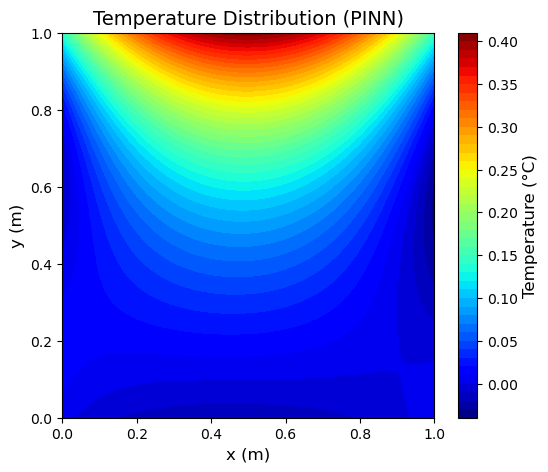

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# 检查Eager模式
print("TensorFlow version:", tf.__version__)
print("Eager Execution:", tf.executing_eagerly()) # 在TF 2.x下通常应为 True

L = 1.0
W = 1.0
k_original = 10.0
q_s_original = 2000.0
T1_original = 30.0

k = 1.0
q_s = 1.0 / L
T1 = 0.0

layers = [2, 128, 128, 128, 1]

N_int = 2000
x_int = np.random.rand(N_int,1)*L
y_int = np.random.rand(N_int,1)*W
X_int = np.hstack((x_int,y_int))

N_bc = 200
y_left = np.random.rand(N_bc,1)*W
x_left = np.zeros_like(y_left)
X_left = np.hstack((x_left,y_left))

y_right = np.random.rand(N_bc,1)*W
x_right = L*np.ones_like(y_right)
X_right = np.hstack((x_right,y_right))

x_bottom = np.random.rand(N_bc,1)*L
y_bottom = np.zeros_like(x_bottom)
X_bottom = np.hstack((x_bottom,y_bottom))

x_top = np.random.rand(N_bc,1)*L
y_top = W*np.ones_like(x_top)
X_top = np.hstack((x_top,y_top))

X_int_tf = tf.convert_to_tensor(X_int, dtype=tf.float32)
X_left_tf = tf.convert_to_tensor(X_left, dtype=tf.float32)
X_right_tf = tf.convert_to_tensor(X_right, dtype=tf.float32)
X_bottom_tf = tf.convert_to_tensor(X_bottom, dtype=tf.float32)
X_top_tf = tf.convert_to_tensor(X_top, dtype=tf.float32)

def neural_net(layers):
    model = tf.keras.Sequential()
    for i in range(len(layers)-1):
        if i < len(layers)-2:
            model.add(tf.keras.layers.Dense(layers[i+1], activation='tanh', 
                                            kernel_initializer='glorot_normal'))
        else:
            model.add(tf.keras.layers.Dense(layers[i+1], activation=None, 
                                            kernel_initializer='glorot_normal'))
    return model

model = neural_net(layers)

def T_model(x, y):
    X = tf.concat([x, y], axis=1)
    return model(X)

def pde_residual(x, y):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        tape2.watch(y)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x)
            tape1.watch(y)
            T_pred = T_model(x, y)
        T_x = tape1.gradient(T_pred, x)
        T_y = tape1.gradient(T_pred, y)
    T_xx = tape2.gradient(T_x, x)
    T_yy = tape2.gradient(T_y, y)
    del tape1, tape2
    return T_xx + T_yy

def loss_fn():
    x_int_tf_ = tf.reshape(X_int_tf[:,0], (-1,1))
    y_int_tf_ = tf.reshape(X_int_tf[:,1], (-1,1))
    res = pde_residual(x_int_tf_, y_int_tf_)
    loss_pde = tf.reduce_mean(tf.square(res))

    T_left = T_model(X_left_tf[:,0:1], X_left_tf[:,1:2])
    loss_left = tf.reduce_mean(tf.square(T_left - T1))

    T_right = T_model(X_right_tf[:,0:1], X_right_tf[:,1:2])
    loss_right = tf.reduce_mean(tf.square(T_right - T1))

    T_bottom = T_model(X_bottom_tf[:,0:1], X_bottom_tf[:,1:2])
    loss_bottom = tf.reduce_mean(tf.square(T_bottom - T1))

    x_top_var = X_top_tf[:,0:1]
    y_top_var = X_top_tf[:,1:2]
    with tf.GradientTape() as tape:
        tape.watch(y_top_var)
        T_top = T_model(x_top_var, y_top_var)
    dT_dy_top = tape.gradient(T_top, y_top_var)
    loss_top = tf.reduce_mean(tf.square(dT_dy_top - (q_s/k)))

    return loss_pde, loss_left, loss_right, loss_bottom, loss_top

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

epochs = 5000

# tbar = trange(epochs)
for epoch in trange(epochs):
    with tf.GradientTape() as tape:
        loss_pde, loss_left, loss_right, loss_bottom, loss_top = loss_fn()
        loss_value = loss_pde + loss_left + loss_right + loss_bottom + loss_top
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss PDE: {loss_pde.numpy()}, Loss BC: {(loss_left+loss_right+loss_bottom+loss_top).numpy()}")

nx, ny = 100, 100
x_plot = np.linspace(0, L, nx)
y_plot = np.linspace(0, W, ny)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)
X_plot_tf = tf.convert_to_tensor(X_plot.reshape(-1,1), dtype=tf.float32)
Y_plot_tf = tf.convert_to_tensor(Y_plot.reshape(-1,1), dtype=tf.float32)

T_pred = T_model(X_plot_tf, Y_plot_tf).numpy().reshape(ny,nx)

plt.figure(figsize=(6,5))
contour = plt.contourf(X_plot, Y_plot, T_pred, levels=50, cmap='jet')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)', fontsize=12)
plt.title('Temperature Distribution (PINN)', fontsize=14)
plt.xlabel('x (m)', fontsize=12)
plt.ylabel('y (m)', fontsize=12)
plt.show()

2024-12-25 09:31:57.357356: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-25 09:31:57.680640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735090317.834943 3589861 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735090317.881351 3589861 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 09:31:58.183010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TensorFlow version: 2.18.0
Eager Execution: True


W0000 00:00:1735090321.218580 3589861 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
  0%|          | 1/5000 [00:00<43:59,  1.89it/s]

Epoch: 0, Loss PDE: 0.0007023770594969392, Loss BC: 0.8585140109062195


  2%|▏         | 102/5000 [00:17<13:11,  6.18it/s]

Epoch: 100, Loss PDE: 0.0329047255218029, Loss BC: 0.07854519039392471


  4%|▍         | 202/5000 [00:33<12:50,  6.22it/s]

Epoch: 200, Loss PDE: 0.018711261451244354, Loss BC: 0.028851287439465523


  6%|▌         | 302/5000 [00:49<13:30,  5.80it/s]

Epoch: 300, Loss PDE: 0.009139963425695896, Loss BC: 0.027836602181196213


  8%|▊         | 402/5000 [01:05<12:32,  6.11it/s]

Epoch: 400, Loss PDE: 0.0014603593153879046, Loss BC: 0.021194040775299072


 10%|█         | 502/5000 [01:21<11:16,  6.65it/s]

Epoch: 500, Loss PDE: 0.001332300715148449, Loss BC: 0.01806192845106125


 12%|█▏        | 602/5000 [01:37<12:08,  6.04it/s]

Epoch: 600, Loss PDE: 0.0017533117206767201, Loss BC: 0.015061075799167156


 14%|█▍        | 702/5000 [01:52<11:15,  6.36it/s]

Epoch: 700, Loss PDE: 0.0020742083434015512, Loss BC: 0.013441748917102814


 16%|█▌        | 802/5000 [02:09<11:09,  6.27it/s]

Epoch: 800, Loss PDE: 0.0020312306005507708, Loss BC: 0.013073740527033806


 18%|█▊        | 902/5000 [02:25<11:16,  6.06it/s]

Epoch: 900, Loss PDE: 0.0021013293880969286, Loss BC: 0.012104075402021408


 20%|██        | 1002/5000 [02:40<10:53,  6.11it/s]

Epoch: 1000, Loss PDE: 0.0022072335705161095, Loss BC: 0.014908053912222385


 22%|██▏       | 1102/5000 [02:56<10:18,  6.31it/s]

Epoch: 1100, Loss PDE: 0.00209660897962749, Loss BC: 0.011221932247281075


 24%|██▍       | 1202/5000 [03:13<10:51,  5.83it/s]

Epoch: 1200, Loss PDE: 0.0020709303207695484, Loss BC: 0.01075601764023304


 26%|██▌       | 1302/5000 [03:29<10:12,  6.04it/s]

Epoch: 1300, Loss PDE: 0.0020213215611875057, Loss BC: 0.010298880748450756


 28%|██▊       | 1402/5000 [03:45<09:13,  6.50it/s]

Epoch: 1400, Loss PDE: 0.0019986454863101244, Loss BC: 0.01012990903109312


 30%|███       | 1502/5000 [04:01<09:45,  5.98it/s]

Epoch: 1500, Loss PDE: 0.0017410152358934283, Loss BC: 0.009561661630868912


 32%|███▏      | 1602/5000 [04:17<08:57,  6.32it/s]

Epoch: 1600, Loss PDE: 0.0013023476349189878, Loss BC: 0.010050998069345951


 34%|███▍      | 1702/5000 [04:32<08:55,  6.16it/s]

Epoch: 1700, Loss PDE: 0.0008988335030153394, Loss BC: 0.008038182742893696


 36%|███▌      | 1802/5000 [04:49<08:05,  6.58it/s]

Epoch: 1800, Loss PDE: 0.0008312654681503773, Loss BC: 0.007440600544214249


 38%|███▊      | 1902/5000 [05:05<08:36,  6.00it/s]

Epoch: 1900, Loss PDE: 0.0012663571396842599, Loss BC: 0.010230469517409801


 40%|████      | 2002/5000 [05:21<08:00,  6.24it/s]

Epoch: 2000, Loss PDE: 0.0008179784053936601, Loss BC: 0.0070547545328736305


 42%|████▏     | 2102/5000 [05:37<08:09,  5.92it/s]

Epoch: 2100, Loss PDE: 0.0007968361605890095, Loss BC: 0.00679957726970315


 44%|████▍     | 2202/5000 [05:53<07:30,  6.21it/s]

Epoch: 2200, Loss PDE: 0.0007483754889108241, Loss BC: 0.0065957410261034966


 46%|████▌     | 2302/5000 [06:09<07:48,  5.76it/s]

Epoch: 2300, Loss PDE: 0.0007372135296463966, Loss BC: 0.007541433908045292


 48%|████▊     | 2402/5000 [06:25<06:29,  6.67it/s]

Epoch: 2400, Loss PDE: 0.0006877275882288814, Loss BC: 0.006334626115858555


 50%|█████     | 2502/5000 [06:41<07:02,  5.91it/s]

Epoch: 2500, Loss PDE: 0.000672421941999346, Loss BC: 0.00628206692636013


 52%|█████▏    | 2602/5000 [06:57<06:17,  6.35it/s]

Epoch: 2600, Loss PDE: 0.000658139237202704, Loss BC: 0.006141955032944679


 54%|█████▍    | 2701/5000 [07:13<05:46,  6.63it/s]

Epoch: 2700, Loss PDE: 0.0011840991210192442, Loss BC: 0.011372823268175125


 56%|█████▌    | 2802/5000 [07:29<05:42,  6.41it/s]

Epoch: 2800, Loss PDE: 0.0006142606725916266, Loss BC: 0.006041508633643389


 58%|█████▊    | 2902/5000 [07:45<05:36,  6.23it/s]

Epoch: 2900, Loss PDE: 0.0006114518619142473, Loss BC: 0.005905826110392809


 60%|██████    | 3002/5000 [08:02<05:29,  6.07it/s]

Epoch: 3000, Loss PDE: 0.0008369054994545877, Loss BC: 0.00674054492264986


 62%|██████▏   | 3102/5000 [08:19<05:47,  5.46it/s]

Epoch: 3100, Loss PDE: 0.0005947105237282813, Loss BC: 0.005719149485230446


 64%|██████▍   | 3202/5000 [08:35<04:58,  6.01it/s]

Epoch: 3200, Loss PDE: 0.0006295969942584634, Loss BC: 0.005843752063810825


 66%|██████▌   | 3302/5000 [08:51<04:47,  5.90it/s]

Epoch: 3300, Loss PDE: 0.0005653987172991037, Loss BC: 0.0055616009049117565


 68%|██████▊   | 3402/5000 [09:07<04:35,  5.80it/s]

Epoch: 3400, Loss PDE: 0.0005383099196478724, Loss BC: 0.0054040164686739445


 70%|███████   | 3502/5000 [09:24<04:06,  6.09it/s]

Epoch: 3500, Loss PDE: 0.0005078217945992947, Loss BC: 0.005233113653957844


 72%|███████▏  | 3602/5000 [09:40<03:37,  6.43it/s]

Epoch: 3600, Loss PDE: 0.0005219679442234337, Loss BC: 0.005208135582506657


 74%|███████▍  | 3702/5000 [09:55<03:17,  6.57it/s]

Epoch: 3700, Loss PDE: 0.0004973486647941172, Loss BC: 0.004991477355360985


 76%|███████▌  | 3802/5000 [10:12<02:59,  6.67it/s]

Epoch: 3800, Loss PDE: 0.0008733893628232181, Loss BC: 0.006029924843460321


 78%|███████▊  | 3902/5000 [10:28<02:54,  6.29it/s]

Epoch: 3900, Loss PDE: 0.0005161139997653663, Loss BC: 0.0046571954153478146


 80%|████████  | 4002/5000 [10:44<02:48,  5.92it/s]

Epoch: 4000, Loss PDE: 0.0005039367242716253, Loss BC: 0.004428785759955645


 82%|████████▏ | 4102/5000 [11:00<02:24,  6.23it/s]

Epoch: 4100, Loss PDE: 0.0005052155465818942, Loss BC: 0.004441786091774702


 84%|████████▍ | 4202/5000 [11:16<02:00,  6.64it/s]

Epoch: 4200, Loss PDE: 0.0004980017547495663, Loss BC: 0.004172897897660732


 86%|████████▌ | 4302/5000 [11:32<02:02,  5.69it/s]

Epoch: 4300, Loss PDE: 0.0005132457008585334, Loss BC: 0.003924758639186621


 88%|████████▊ | 4402/5000 [11:49<01:31,  6.55it/s]

Epoch: 4400, Loss PDE: 0.0005077606183476746, Loss BC: 0.003932409919798374


 90%|█████████ | 4502/5000 [12:05<01:24,  5.87it/s]

Epoch: 4500, Loss PDE: 0.000520597561262548, Loss BC: 0.003697821404784918


 92%|█████████▏| 4602/5000 [12:21<01:02,  6.42it/s]

Epoch: 4600, Loss PDE: 0.000540860288310796, Loss BC: 0.00351479509845376


 94%|█████████▍| 4702/5000 [12:37<00:47,  6.34it/s]

Epoch: 4700, Loss PDE: 0.0005053057102486491, Loss BC: 0.003639939706772566


 96%|█████████▌| 4802/5000 [12:53<00:32,  6.13it/s]

Epoch: 4800, Loss PDE: 0.0005036325310356915, Loss BC: 0.0033554646652191877


 98%|█████████▊| 4902/5000 [13:09<00:16,  5.87it/s]

Epoch: 4900, Loss PDE: 0.0006494976114481688, Loss BC: 0.003857332281768322


100%|██████████| 5000/5000 [13:25<00:00,  6.21it/s]


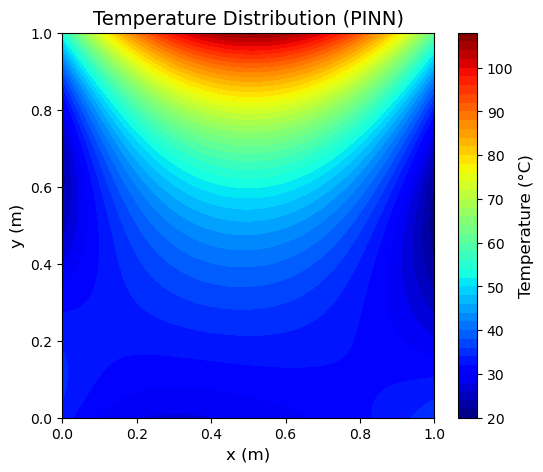

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# 检查Eager模式
print("TensorFlow version:", tf.__version__)
print("Eager Execution:", tf.executing_eagerly()) # 在TF 2.x下通常应为 True

L = 1.0
W = 1.0
k_original = 10.0
q_s_original = 2000.0
T1_original = 30.0

k = 1.0
q_s = 1.0 / L
T1 = 0.0

layers = [2, 128, 128, 128, 1]

N_int = 2000
x_int = np.random.rand(N_int,1)*L
y_int = np.random.rand(N_int,1)*W
X_int = np.hstack((x_int,y_int))

N_bc = 200
y_left = np.random.rand(N_bc,1)*W
x_left = np.zeros_like(y_left)
X_left = np.hstack((x_left,y_left))

y_right = np.random.rand(N_bc,1)*W
x_right = L*np.ones_like(y_right)
X_right = np.hstack((x_right,y_right))

x_bottom = np.random.rand(N_bc,1)*L
y_bottom = np.zeros_like(x_bottom)
X_bottom = np.hstack((x_bottom,y_bottom))

x_top = np.random.rand(N_bc,1)*L
y_top = W*np.ones_like(x_top)
X_top = np.hstack((x_top,y_top))

X_int_tf = tf.convert_to_tensor(X_int, dtype=tf.float32)
X_left_tf = tf.convert_to_tensor(X_left, dtype=tf.float32)
X_right_tf = tf.convert_to_tensor(X_right, dtype=tf.float32)
X_bottom_tf = tf.convert_to_tensor(X_bottom, dtype=tf.float32)
X_top_tf = tf.convert_to_tensor(X_top, dtype=tf.float32)

def neural_net(layers):
    model = tf.keras.Sequential()
    for i in range(len(layers)-1):
        if i < len(layers)-2:
            model.add(tf.keras.layers.Dense(layers[i+1], activation='tanh', 
                                            kernel_initializer='glorot_normal'))
        else:
            model.add(tf.keras.layers.Dense(layers[i+1], activation=None, 
                                            kernel_initializer='glorot_normal'))
    return model

model = neural_net(layers)

def T_model(x, y):
    X = tf.concat([x, y], axis=1)
    return model(X)

def pde_residual(x, y):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        tape2.watch(y)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x)
            tape1.watch(y)
            T_pred = T_model(x, y)
        T_x = tape1.gradient(T_pred, x)
        T_y = tape1.gradient(T_pred, y)
    T_xx = tape2.gradient(T_x, x)
    T_yy = tape2.gradient(T_y, y)
    del tape1, tape2
    return T_xx + T_yy

def loss_fn():
    x_int_tf_ = tf.reshape(X_int_tf[:,0], (-1,1))
    y_int_tf_ = tf.reshape(X_int_tf[:,1], (-1,1))
    res = pde_residual(x_int_tf_, y_int_tf_)
    loss_pde = tf.reduce_mean(tf.square(res))

    T_left = T_model(X_left_tf[:,0:1], X_left_tf[:,1:2])
    loss_left = tf.reduce_mean(tf.square(T_left - T1))

    T_right = T_model(X_right_tf[:,0:1], X_right_tf[:,1:2])
    loss_right = tf.reduce_mean(tf.square(T_right - T1))

    T_bottom = T_model(X_bottom_tf[:,0:1], X_bottom_tf[:,1:2])
    loss_bottom = tf.reduce_mean(tf.square(T_bottom - T1))

    x_top_var = X_top_tf[:,0:1]
    y_top_var = X_top_tf[:,1:2]
    with tf.GradientTape() as tape:
        tape.watch(y_top_var)
        T_top = T_model(x_top_var, y_top_var)
    dT_dy_top = tape.gradient(T_top, y_top_var)
    loss_top = tf.reduce_mean(tf.square(dT_dy_top - (q_s/k)))

    return loss_pde, loss_left, loss_right, loss_bottom, loss_top

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

epochs = 5000

# tbar = trange(epochs)
for epoch in trange(epochs):
    with tf.GradientTape() as tape:
        loss_pde, loss_left, loss_right, loss_bottom, loss_top = loss_fn()
        loss_value = loss_pde + loss_left + loss_right + loss_bottom + loss_top
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss PDE: {loss_pde.numpy()}, Loss BC: {(loss_left+loss_right+loss_bottom+loss_top).numpy()}")

nx, ny = 100, 100
x_plot = np.linspace(0, L, nx)
y_plot = np.linspace(0, W, ny)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)
X_plot_tf = tf.convert_to_tensor(X_plot.reshape(-1,1), dtype=tf.float32)
Y_plot_tf = tf.convert_to_tensor(Y_plot.reshape(-1,1), dtype=tf.float32)

T_pred = T_model(X_plot_tf, Y_plot_tf).numpy().reshape(ny,nx)
T_actual = T_pred * (q_s_original * L / k_original) + T1_original

plt.figure(figsize=(6,5))
contour = plt.contourf(X_plot, Y_plot, T_actual, levels=50, cmap='jet')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)', fontsize=12)
plt.title('Temperature Distribution (PINN)', fontsize=14)
plt.xlabel('x (m)', fontsize=12)
plt.ylabel('y (m)', fontsize=12)
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# 检查Eager模式
print("TensorFlow version:", tf.__version__)
print("Eager Execution:", tf.executing_eagerly()) # 在TF 2.x下通常应为 True

L = 1.0
W = 1.0
k_original = 10.0
q_s_original = 2000.0
T1_original = 30.0

k = 1.0
q_s = 1.0 / L
T1 = 0.0

layers = [2, 128, 128, 128, 1]

N_int = 2000
x_int = np.random.rand(N_int,1)*L
y_int = np.random.rand(N_int,1)*W
X_int = np.hstack((x_int,y_int))

N_bc = 200
y_left = np.random.rand(N_bc,1)*W
x_left = np.zeros_like(y_left)
X_left = np.hstack((x_left,y_left))

y_right = np.random.rand(N_bc,1)*W
x_right = L*np.ones_like(y_right)
X_right = np.hstack((x_right,y_right))

x_bottom = np.random.rand(N_bc,1)*L
y_bottom = np.zeros_like(x_bottom)
X_bottom = np.hstack((x_bottom,y_bottom))

x_top = np.random.rand(N_bc,1)*L
y_top = W*np.ones_like(x_top)
X_top = np.hstack((x_top,y_top))

X_int_tf = tf.convert_to_tensor(X_int, dtype=tf.float32)
X_left_tf = tf.convert_to_tensor(X_left, dtype=tf.float32)
X_right_tf = tf.convert_to_tensor(X_right, dtype=tf.float32)
X_bottom_tf = tf.convert_to_tensor(X_bottom, dtype=tf.float32)
X_top_tf = tf.convert_to_tensor(X_top, dtype=tf.float32)

def neural_net(layers):
    model = tf.keras.Sequential()
    for i in range(len(layers)-1):
        if i < len(layers)-2:
            model.add(tf.keras.layers.Dense(layers[i+1], activation='tanh', 
                                            kernel_initializer='glorot_normal'))
        else:
            model.add(tf.keras.layers.Dense(layers[i+1], activation=None, 
                                            kernel_initializer='glorot_normal'))
    return model

model = neural_net(layers)

def T_model(x, y):
    X = tf.concat([x, y], axis=1)
    return model(X)

def pde_residual(x, y):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        tape2.watch(y)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x)
            tape1.watch(y)
            T_pred = T_model(x, y)
        T_x = tape1.gradient(T_pred, x)
        T_y = tape1.gradient(T_pred, y)
    T_xx = tape2.gradient(T_x, x)
    T_yy = tape2.gradient(T_y, y)
    del tape1, tape2
    return T_xx + T_yy

def loss_fn():
    x_int_tf_ = tf.reshape(X_int_tf[:,0], (-1,1))
    y_int_tf_ = tf.reshape(X_int_tf[:,1], (-1,1))
    res = pde_residual(x_int_tf_, y_int_tf_)
    loss_pde = tf.reduce_mean(tf.square(res))

    T_left = T_model(X_left_tf[:,0:1], X_left_tf[:,1:2])
    loss_left = tf.reduce_mean(tf.square(T_left - T1))

    T_right = T_model(X_right_tf[:,0:1], X_right_tf[:,1:2])
    loss_right = tf.reduce_mean(tf.square(T_right - T1))

    T_bottom = T_model(X_bottom_tf[:,0:1], X_bottom_tf[:,1:2])
    loss_bottom = tf.reduce_mean(tf.square(T_bottom - T1))

    x_top_var = X_top_tf[:,0:1]
    y_top_var = X_top_tf[:,1:2]
    with tf.GradientTape() as tape:
        tape.watch(y_top_var)
        T_top = T_model(x_top_var, y_top_var)
    dT_dy_top = tape.gradient(T_top, y_top_var)
    loss_top = tf.reduce_mean(tf.square(dT_dy_top - (q_s/k)))

    return loss_pde, loss_left, loss_right, loss_bottom, loss_top

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

epochs = 5000

# tbar = trange(epochs)
for epoch in trange(epochs):
    with tf.GradientTape() as tape:
        loss_pde, loss_left, loss_right, loss_bottom, loss_top = loss_fn()
        loss_value = loss_pde + loss_left + loss_right + loss_bottom + loss_top
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss PDE: {loss_pde.numpy()}, Loss BC: {(loss_left+loss_right+loss_bottom+loss_top).numpy()}")

nx, ny = 100, 100
x_plot = np.linspace(0, L, nx)
y_plot = np.linspace(0, W, ny)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)
X_plot_tf = tf.convert_to_tensor(X_plot.reshape(-1,1), dtype=tf.float32)
Y_plot_tf = tf.convert_to_tensor(Y_plot.reshape(-1,1), dtype=tf.float32)

T_pred = T_model(X_plot_tf, Y_plot_tf).numpy().reshape(ny,nx)

plt.figure(figsize=(6,5))
contour = plt.contourf(X_plot, Y_plot, T_pred, levels=50, cmap='jet')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)', fontsize=12)
plt.title('Temperature Distribution (PINN)', fontsize=14)
plt.xlabel('x (m)', fontsize=12)
plt.ylabel('y (m)', fontsize=12)
plt.show()

相对误差

In [ ]:
import numpy as np

# 已知参数
L = 1.0
W = 1.0
k = 10.0
q_s = 2000.0
T1 = 30.0

# 给定解析解函数 (与之前代码中相同)
def temperature_distribution(x, y, L, W, q_s, k, T1, terms=200):
    T = T1
    for n in range(1, terms + 1):
        coefficient = (2 * (-1)**(n + 1) + 1) / (n**2 * np.pi**2 * np.cosh(n * np.pi * W / L))
        term = coefficient * np.sin(n * np.pi * x / L) * np.sinh(n * np.pi * y / L)
        T += (q_s * L / k) * term
    return T

# 假设已通过 PINN 得到以下数据：
# X_plot, Y_plot: (ny,nx)网格点坐标
# T_pred: (ny,nx) PINN在该网格上的预测温度

# 使用解析解计算相同网格点处的温度
T_exact = temperature_distribution(X_plot, Y_plot, L, W, q_s, k, T1, terms=200)

# 计算L2相对误差范数
diff = T_pred - T_exact
diff_squared = diff**2
exact_squared = T_exact**2

L2_diff = np.sqrt(np.mean(diff_squared))
L2_exact = np.sqrt(np.mean(exact_squared))

relative_error = L2_diff / L2_exact
print("Relative Error:", relative_error)

Relative Error: 0.14119126628253684


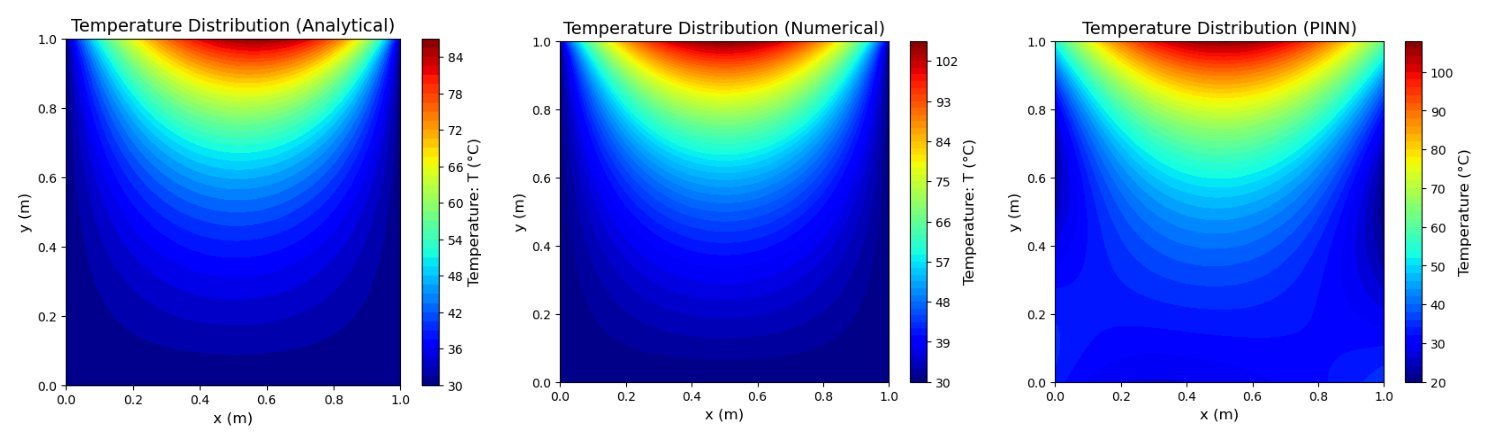

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 加载图像
img1 = mpimg.imread('/home/wangjiaxin/workspace/hf project/图片7.png')  # 替换为图1路径
img2 = mpimg.imread('/home/wangjiaxin/workspace/hf project/图片8.png')  # 替换为图2路径
img3 = mpimg.imread('/home/wangjiaxin/workspace/hf project/图片6.png')  # 替换为图3路径

# 创建子图
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 图1
axes[0].imshow(img1)
axes[0].axis('off')  # 隐藏坐标轴

# 图2
axes[1].imshow(img2)
axes[1].axis('off')

# 图3
axes[2].imshow(img3)
axes[2].axis('off')

# 调整布局并显示
plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange

# 解析解函数
def temperature_distribution(x, y, L, W, q_s, k, T1, terms=200):
    T = T1  # 起始温度为边界温度
    for n in range(1, terms + 1):
        # 解析解中的各项计算
        coefficient = (2 * (-1)**(n + 1) + 1) / (n**2 * np.pi**2 * np.cosh(n * np.pi * W / L))
        term = coefficient * np.sin(n * np.pi * x / L) * np.sinh(n * np.pi * y / L)
        T += (q_s * L / k) * term
    return T

# 网格设置
L = 1.0
W = 1.0
k = 10.0
q_s = 2000.0
T1 = 30.0
nx, ny = 100, 100
x_plot = np.linspace(0, L, nx)
y_plot = np.linspace(0, W, ny)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# 计算解析解
T_analytical = temperature_distribution(X_plot, Y_plot, L, W, q_s, k, T1)

# 将网格转换为TensorFlow的输入形式
X_plot_tf = tf.convert_to_tensor(X_plot.reshape(-1, 1), dtype=tf.float32)
Y_plot_tf = tf.convert_to_tensor(Y_plot.reshape(-1, 1), dtype=tf.float32)

# PINN模型（假设模型已训练）
def neural_net(layers):
    model = tf.keras.Sequential()
    for i in range(len(layers) - 1):
        if i < len(layers) - 2:
            model.add(tf.keras.layers.Dense(layers[i+1], activation='tanh', kernel_initializer='glorot_normal'))
        else:
            model.add(tf.keras.layers.Dense(layers[i+1], activation=None, kernel_initializer='glorot_normal'))
    return model

# 使用训练好的PINN模型进行预测
def T_model(x, y):
    X = tf.concat([x, y], axis=1)
    return model(X)

# 假设模型已经训练好了，下面是预测部分
T_pred = T_model(X_plot_tf, Y_plot_tf).numpy().reshape(ny, nx)

# 计算数值解（通过Gauss-Seidel方法，假设已经计算好了数值解）
# 数值解的计算请参考之前的Gauss-Seidel方法代码
T_num = np.zeros((nx, ny)) + T1
# （数值解的代码已经给出，假设T_num已经计算完）

# 计算误差（MSE）
error_pinn_analytical = np.mean((T_analytical - T_pred) ** 2)
error_num_analytical = np.mean((T_analytical - T_num) ** 2)
error_pinn_num = np.mean((T_pred - T_num) ** 2)

# 输出误差
print(f"MSE between PINN and Analytical: {error_pinn_analytical}")
print(f"MSE between Numerical and Analytical: {error_num_analytical}")
print(f"MSE between PINN and Numerical: {error_pinn_num}")

# 绘制误差图
plt.figure(figsize=(12, 6))

# 绘制PINN与解析解的误差图
plt.subplot(1, 3, 1)
contour = plt.contourf(X_plot, Y_plot, T_analytical - T_pred, levels=50, cmap='jet')
plt.colorbar(contour)
plt.title('Error: PINN vs Analytical')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

# 绘制数值解与解析解的误差图
plt.subplot(1, 3, 2)
contour = plt.contourf(X_plot, Y_plot, T_analytical - T_num, levels=50, cmap='jet')
plt.colorbar(contour)
plt.title('Error: Numerical vs Analytical')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

# 绘制PINN与数值解的误差图
plt.subplot(1, 3, 3)
contour = plt.contourf(X_plot, Y_plot, T_pred - T_num, levels=50, cmap='jet')
plt.colorbar(contour)
plt.title('Error: PINN vs Numerical')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.tight_layout()
plt.show()


2024-12-27 12:40:43.852776: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-27 12:40:44.162532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735274444.319158 3881044 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735274444.367871 3881044 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 12:40:44.675400: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

NameError: name 'model' is not defined

In [4]:
# 将代码保存到文件
code_content = """
import numpy as np
import matplotlib.pyplot as plt

# 参数定义
L = 1.0  # 板长 (m)
W = 1.0  # 板宽 (m)
k = 10.0  # 导热系数 (W/m·K)
q_s = 2000.0  # 热流密度 (W/m^2)
T1 = 30.0  # 边界温度 (°C)

# 解析解实现
def temperature_distribution(x, y, L, W, q_s, k, T1, terms=200):
    T = T1  # 起始温度为边界温度
    for n in range(1, terms + 1):
        # 解析解中的各项计算
        coefficient = (2 * (-1)**(n + 1) + 1) / (n**2 * np.pi**2 * np.cosh(n * np.pi * W / L))
        term = coefficient * np.sin(n * np.pi * x / L) * np.sinh(n * np.pi * y / L)
        T += (q_s * L / k) * term
    return T

# 创建网格
x = np.linspace(0, L, 100)
y = np.hstack([
    np.linspace(0, 0.1 * W, 50),  # 在 0 到 0.1W 的区域更密
    np.linspace(0.1 * W, W, 50)  # 在 0.1W 到 W 的区域较疏
])
X, Y = np.meshgrid(x, y)

# 计算温度分布
T = temperature_distribution(X, Y, L, W, q_s, k, T1)

# 绘制温度分布图
plt.figure(figsize=(6, 5))
contour = plt.contourf(X, Y, T, levels=50, cmap='jet')  # 使用 'jet' 配色方案
cbar = plt.colorbar(contour)
cbar.set_label('Temperature: T (°C)', fontsize=12)
cbar.ax.tick_params(labelsize=10)
plt.title('Temperature Distribution (Analytical)', fontsize=14)
plt.xlabel('x (m)', fontsize=12)
plt.ylabel('y (m)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
"""

# 保存为 Python 文件
file_path = "temperature_distribution_plot.py"
with open(file_path, "w") as file:
    file.write(code_content)

file_path


'temperature_distribution_plot.py'

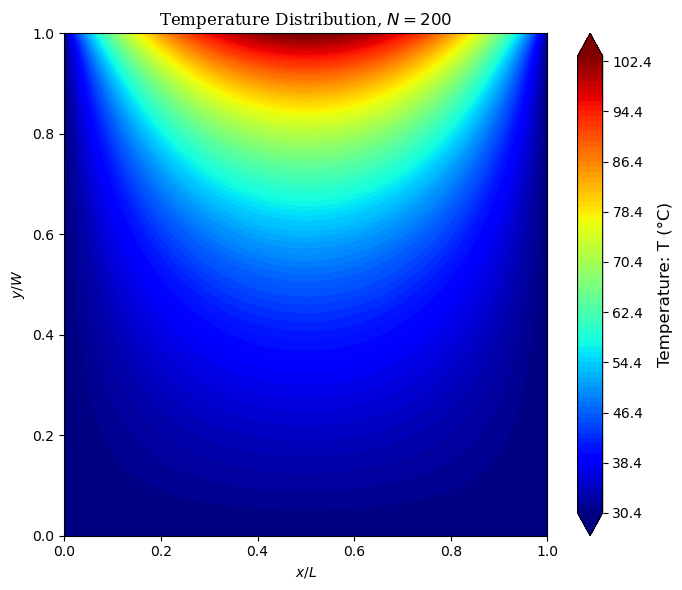

In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm

# 参数定义
L = 1.0  # 板长
W = 1.0  # 板宽
M = 200  # x方向网格数
N = 200  # y方向网格数
q = 2000  # 热流密度
k = 10  # 导热系数
T_base = 30.0  # 基础温度
pi = math.pi

# 创建网格
x = np.linspace(0, L, M)
y = np.linspace(0, W, N)
X, Y = np.meshgrid(x, y)

# 展开项数
Nterm = 200

# 初始化温度矩阵
T = np.zeros((M, N))

# 解析解计算
for n in range(1, Nterm + 1):
    coefficient = (2 * ((-1) ** (n + 1) + 1)) / (n ** 2 * pi ** 2 * math.cosh(n * pi * W / L))
    term = (
        coefficient
        * np.sin(n * pi * X / L)
        * np.sinh(n * pi * Y / L)
    )
    T += (q * L / k) * term

# 加上基准温度
T += T_base

# 绘制温度分布图
plt.figure(figsize=(7, 6))
plt.title("Temperature Distribution, $N = 200$", fontname="serif")
contour = plt.contourf(X, Y, T, levels=100, cmap=cm.jet, extend="both")
plt.xlabel("$x/L$", fontname="serif")
plt.ylabel("$y/W$", fontname="serif")
cbar = plt.colorbar(contour)
cbar.set_label("Temperature: T (°C)", fontsize=12)
plt.tight_layout()
plt.savefig("plate.pdf")
plt.show()


In [27]:
# The environment was reset, re-adding the code to save it to a file.

code = """
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm

# 参数定义
L = 1.0  # 板长
W = 1.0  # 板宽
M = 200  # x方向网格数
N = 200  # y方向网格数
q = 2000  # 热流密度
k = 10  # 导热系数
T_base = 30.0  # 基础温度
pi = math.pi

# 创建网格
x = np.linspace(0, L, M)
y = np.linspace(0, W, N)
X, Y = np.meshgrid(x, y)

# 展开项数
Nterm = 200

# 初始化温度矩阵
T = np.zeros((M, N))

# 解析解计算
for n in range(1, Nterm + 1):
    coefficient = (2 * ((-1) ** (n + 1) + 1)) / (n ** 2 * pi ** 2 * math.cosh(n * pi * W / L))
    term = (
        coefficient
        * np.sin(n * pi * X / L)
        * np.sinh(n * pi * Y / L)
    )
    T += (q * L / k) * term

# 加上基准温度
T += T_base

# 绘制温度分布图
plt.figure(figsize=(7, 6))
plt.title("Temperature Distribution, $N = 200$", fontname="serif")
contour = plt.contourf(X, Y, T, levels=100, cmap=cm.jet, extend="both")
plt.xlabel("$x/L$", fontname="serif")
plt.ylabel("$y/W$", fontname="serif")
cbar = plt.colorbar(contour)
cbar.set_label("Temperature: T (°C)", fontsize=12)
plt.tight_layout()
plt.savefig("plate.pdf")
plt.show()
"""

file_path = "/mnt/data/temperature_distribution.py"

with open(file_path, "w") as file:
    file.write(code)

file_path


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/temperature_distribution.py'

In [5]:
# 将代码保存到文件
numerical_code_content = """
import numpy as np
import matplotlib.pyplot as plt

# 参数定义
L = 1.0   # 板长 (m)
W = 1.0   # 板宽 (m)
k = 10.0  # 导热系数 (W/m·K)
q_s = 2000.0  # 热流密度 (W/m^2)
T1 = 30.0     # 边界温度 (°C)

# 网格划分
Nx = 51
Ny = 51
dx = L/(Nx-1)
dy = W/(Ny-1)

# 初始化温度场
T = np.zeros((Nx, Ny)) + T1

# 设置Dirichlet边界条件（左、右、下）
T[0, :] = T1    # 左边界
T[-1, :] = T1   # 右边界
T[:, 0] = T1    # 下边界

# 收敛标准
tol = 1e-5
max_iter = 100000
error = 1.0
iter_count = 0

# 如果q_s向下，则q_s在坐标系中是负方向热流：q_s = -2000 W/m²
# q_s = -k dT/dy => -2000 = -10 dT/dy => dT/dy = 200 °C/m
# 顶部边界条件: T[i,Ny-1] = T[i,Ny-2] + 200*dy

while error > tol and iter_count < max_iter:
    error = 0.0
    T_old = T.copy()
    
    # 应用顶部Neumann边界条件
    for i in range(Nx):
        T[i, Ny-1] = T[i, Ny-2] + 200.0 * dy  # 修改为加号

    # 内点更新（Gauss-Seidel迭代）
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            # 顶部已由Neumann设置，这里仍可更新内部点
            # 但要注意顶部最上一行由Neumann给定不需更新
            if j < Ny-1:
                T[i,j] = 0.25*(T[i+1,j] + T[i-1,j] + T[i,j+1] + T[i,j-1])

    # 计算误差
    error = np.max(np.abs(T - T_old))
    iter_count += 1

print("迭代次数:", iter_count)
print("最大误差:", error)

# 绘图
x = np.linspace(0, L, Nx)
y = np.linspace(0, W, Ny)
X, Y = np.meshgrid(x, y, indexing='ij')

plt.figure(figsize=(6,5))
contour = plt.contourf(X, Y, T, 50, cmap='jet')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature: T (°C)', fontsize=12)
plt.title('Temperature Distribution (Numerical)', fontsize=14)
plt.xlabel('x (m)', fontsize=12)
plt.ylabel('y (m)', fontsize=12)
plt.show()
"""

# 保存为 Python 文件
numerical_file_path = "numerical_temperature_distribution.py"
with open(numerical_file_path, "w") as file:
    file.write(numerical_code_content)

numerical_file_path


'numerical_temperature_distribution.py'

In [6]:
# 将代码保存到文件
pinn_code_content = """
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# 检查Eager模式
print("TensorFlow version:", tf.__version__)
print("Eager Execution:", tf.executing_eagerly()) # 在TF 2.x下通常应为 True

L = 1.0
W = 1.0
k_original = 10.0
q_s_original = 2000.0
T1_original = 30.0

k = 1.0
q_s = 1.0 / L
T1 = 0.0

layers = [2, 128, 128, 128, 1]

N_int = 2000
x_int = np.random.rand(N_int,1)*L
y_int = np.random.rand(N_int,1)*W
X_int = np.hstack((x_int,y_int))

N_bc = 200
y_left = np.random.rand(N_bc,1)*W
x_left = np.zeros_like(y_left)
X_left = np.hstack((x_left,y_left))

y_right = np.random.rand(N_bc,1)*W
x_right = L*np.ones_like(y_right)
X_right = np.hstack((x_right,y_right))

x_bottom = np.random.rand(N_bc,1)*L
y_bottom = np.zeros_like(x_bottom)
X_bottom = np.hstack((x_bottom,y_bottom))

x_top = np.random.rand(N_bc,1)*L
y_top = W*np.ones_like(x_top)
X_top = np.hstack((x_top,y_top))

X_int_tf = tf.convert_to_tensor(X_int, dtype=tf.float32)
X_left_tf = tf.convert_to_tensor(X_left, dtype=tf.float32)
X_right_tf = tf.convert_to_tensor(X_right, dtype=tf.float32)
X_bottom_tf = tf.convert_to_tensor(X_bottom, dtype=tf.float32)
X_top_tf = tf.convert_to_tensor(X_top, dtype=tf.float32)

def neural_net(layers):
    model = tf.keras.Sequential()
    for i in range(len(layers)-1):
        if i < len(layers)-2:
            model.add(tf.keras.layers.Dense(layers[i+1], activation='tanh', 
                                            kernel_initializer='glorot_normal'))
        else:
            model.add(tf.keras.layers.Dense(layers[i+1], activation=None, 
                                            kernel_initializer='glorot_normal'))
    return model

model = neural_net(layers)

def T_model(x, y):
    X = tf.concat([x, y], axis=1)
    return model(X)

def pde_residual(x, y):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        tape2.watch(y)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x)
            tape1.watch(y)
            T_pred = T_model(x, y)
        T_x = tape1.gradient(T_pred, x)
        T_y = tape1.gradient(T_pred, y)
    T_xx = tape2.gradient(T_x, x)
    T_yy = tape2.gradient(T_y, y)
    del tape1, tape2
    return T_xx + T_yy

def loss_fn():
    x_int_tf_ = tf.reshape(X_int_tf[:,0], (-1,1))
    y_int_tf_ = tf.reshape(X_int_tf[:,1], (-1,1))
    res = pde_residual(x_int_tf_, y_int_tf_)
    loss_pde = tf.reduce_mean(tf.square(res))

    T_left = T_model(X_left_tf[:,0:1], X_left_tf[:,1:2])
    loss_left = tf.reduce_mean(tf.square(T_left - T1))

    T_right = T_model(X_right_tf[:,0:1], X_right_tf[:,1:2])
    loss_right = tf.reduce_mean(tf.square(T_right - T1))

    T_bottom = T_model(X_bottom_tf[:,0:1], X_bottom_tf[:,1:2])
    loss_bottom = tf.reduce_mean(tf.square(T_bottom - T1))

    x_top_var = X_top_tf[:,0:1]
    y_top_var = X_top_tf[:,1:2]
    with tf.GradientTape() as tape:
        tape.watch(y_top_var)
        T_top = T_model(x_top_var, y_top_var)
    dT_dy_top = tape.gradient(T_top, y_top_var)
    loss_top = tf.reduce_mean(tf.square(dT_dy_top - (q_s/k)))

    return loss_pde, loss_left, loss_right, loss_bottom, loss_top

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

epochs = 5000

# tbar = trange(epochs)
for epoch in trange(epochs):
    with tf.GradientTape() as tape:
        loss_pde, loss_left, loss_right, loss_bottom, loss_top = loss_fn()
        loss_value = loss_pde + loss_left + loss_right + loss_bottom + loss_top
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss PDE: {loss_pde.numpy()}, Loss BC: {(loss_left+loss_right+loss_bottom+loss_top).numpy()}")

nx, ny = 100, 100
x_plot = np.linspace(0, L, nx)
y_plot = np.linspace(0, W, ny)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)
X_plot_tf = tf.convert_to_tensor(X_plot.reshape(-1,1), dtype=tf.float32)
Y_plot_tf = tf.convert_to_tensor(Y_plot.reshape(-1,1), dtype=tf.float32)

T_pred = T_model(X_plot_tf, Y_plot_tf).numpy().reshape(ny,nx)
T_actual = T_pred * (q_s_original * L / k_original) + T1_original

plt.figure(figsize=(6,5))
contour = plt.contourf(X_plot, Y_plot, T_actual, levels=50, cmap='jet')
cbar = plt.colorbar(contour)
cbar.set_label('Temperature (°C)', fontsize=12)
plt.title('Temperature Distribution (PINN)', fontsize=14)
plt.xlabel('x (m)', fontsize=12)
plt.ylabel('y (m)', fontsize=12)
plt.show()
"""

# 保存为 Python 文件
pinn_file_path = "pinn_temperature_distribution.py"
with open(pinn_file_path, "w") as file:
    file.write(pinn_code_content)

pinn_file_path


'pinn_temperature_distribution.py'

Grid mismatch detected. Interpolating data to a common grid.
X_num shape: (51, 51) Y_num shape: (51, 51) T_num shape: (51, 51)
X_pinn shape: (100, 100) Y_pinn shape: (100, 100) T_pinn shape: (100, 100)


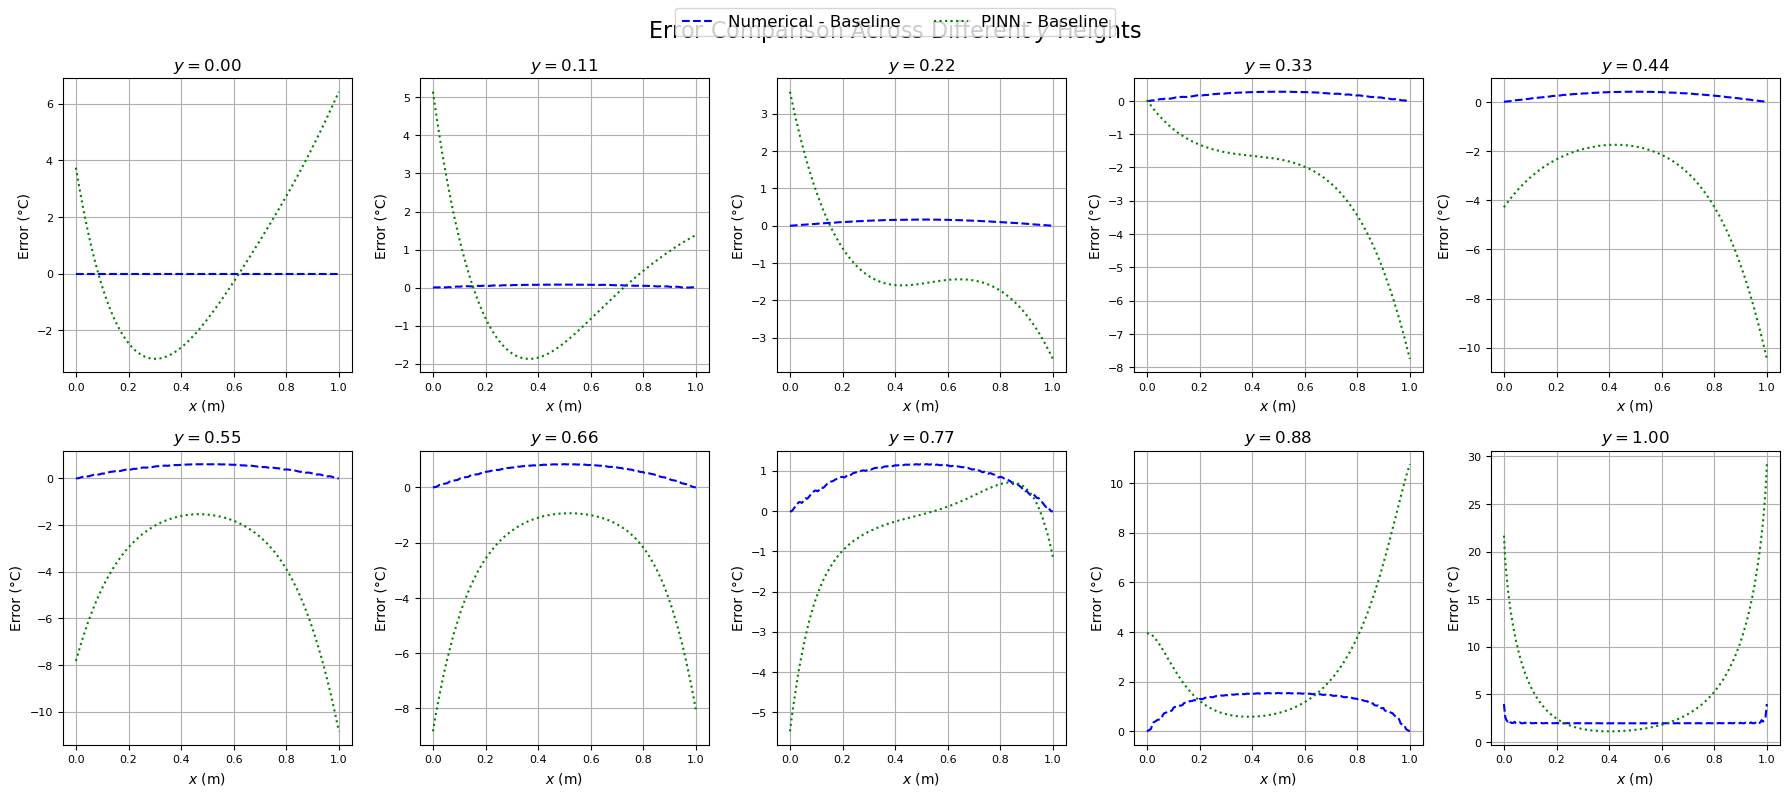

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 从 Python 文件加载数据
from data_4 import X as X_exact, Y as Y_exact, T as T_exact
from data_2 import X as X_num, Y as Y_num, T as T_num
from data_3 import X_plot as X_pinn, Y_plot as Y_pinn, T_actual as T_pinn

# 验证网格一致性，如果不一致则插值到统一网格
if not (np.array_equal(X_exact, X_num) and np.array_equal(X_exact, X_pinn)):
    print("Grid mismatch detected. Interpolating data to a common grid.")
    # 定义统一的网格
    x_common = X_exact[0, :]
    y_common = Y_exact[:, 0]
    X_common, Y_common = np.meshgrid(x_common, y_common)

    # 调试信息：检查数据形状
    print("X_num shape:", X_num.shape, "Y_num shape:", Y_num.shape, "T_num shape:", T_num.shape)
    print("X_pinn shape:", X_pinn.shape, "Y_pinn shape:", Y_pinn.shape, "T_pinn shape:", T_pinn.shape)

    # 确保形状一致
    if X_num.shape != T_num.shape or X_pinn.shape != T_pinn.shape:
        raise ValueError("Shape mismatch among data sources.")

    # 插值数值解和 PINN 解到统一网格
    try:
        T_num = griddata(
            (X_num.ravel(), Y_num.ravel()), T_num.ravel(),
            (X_common, Y_common), method='linear'
        )
        T_pinn = griddata(
            (X_pinn.ravel(), Y_pinn.ravel()), T_pinn.ravel(),
            (X_common, Y_common), method='linear'
        )
    except ValueError as e:
        print(f"Interpolation failed: {e}")
        print("Falling back to nearest-neighbor interpolation...")
        T_num = griddata(
            (X_num.ravel(), Y_num.ravel()), T_num.ravel(),
            (X_common, Y_common), method='nearest'
        )
        T_pinn = griddata(
            (X_pinn.ravel(), Y_pinn.ravel()), T_pinn.ravel(),
            (X_common, Y_common), method='nearest'
        )

# 网格定义
x = X_exact[0, :]
y = Y_exact[:, 0]
ny = len(y)
y_indices = np.linspace(0, ny - 1, 10, dtype=int)  # 选择 10 个高度切片
y_selected = y[y_indices]

# 基准选择：以解析解为基准
baseline = T_exact

# 计算误差
error_num = T_num - baseline  # 数值解与基准的误差
error_pinn = T_pinn - baseline  # PINN 与基准的误差

# 绘制误差曲线
fig, axes = plt.subplots(2, 5, figsize=(18, 8))  # 创建 2 行 5 列的子图布局

for idx, ax in enumerate(axes.flatten()):
    y_idx = y_indices[idx]  # 当前 y 索引
    # 提取当前 y 水平的误差切片
    error_num_slice = error_num[y_idx, :]
    error_pinn_slice = error_pinn[y_idx, :]

    # 绘制误差曲线
    ax.plot(x, error_num_slice, label="Numerical - Baseline", color="blue", linestyle="--")
    ax.plot(x, error_pinn_slice, label="PINN - Baseline", color="green", linestyle=":")

    # 设置标题和标签
    ax.set_title(f"$y = {y_selected[idx]:.2f}$", fontsize=12)
    ax.set_xlabel("$x$ (m)", fontsize=10)
    ax.set_ylabel("Error (°C)", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True)

# 设置全局图例
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局
plt.suptitle("Error Comparison Across Different $y$ Heights", fontsize=16)
plt.show()


Grid mismatch detected. Interpolating data to a common grid.
X_num shape: (51, 51) Y_num shape: (51, 51) T_num shape: (51, 51)
X_pinn shape: (100, 100) Y_pinn shape: (100, 100) T_pinn shape: (100, 100)


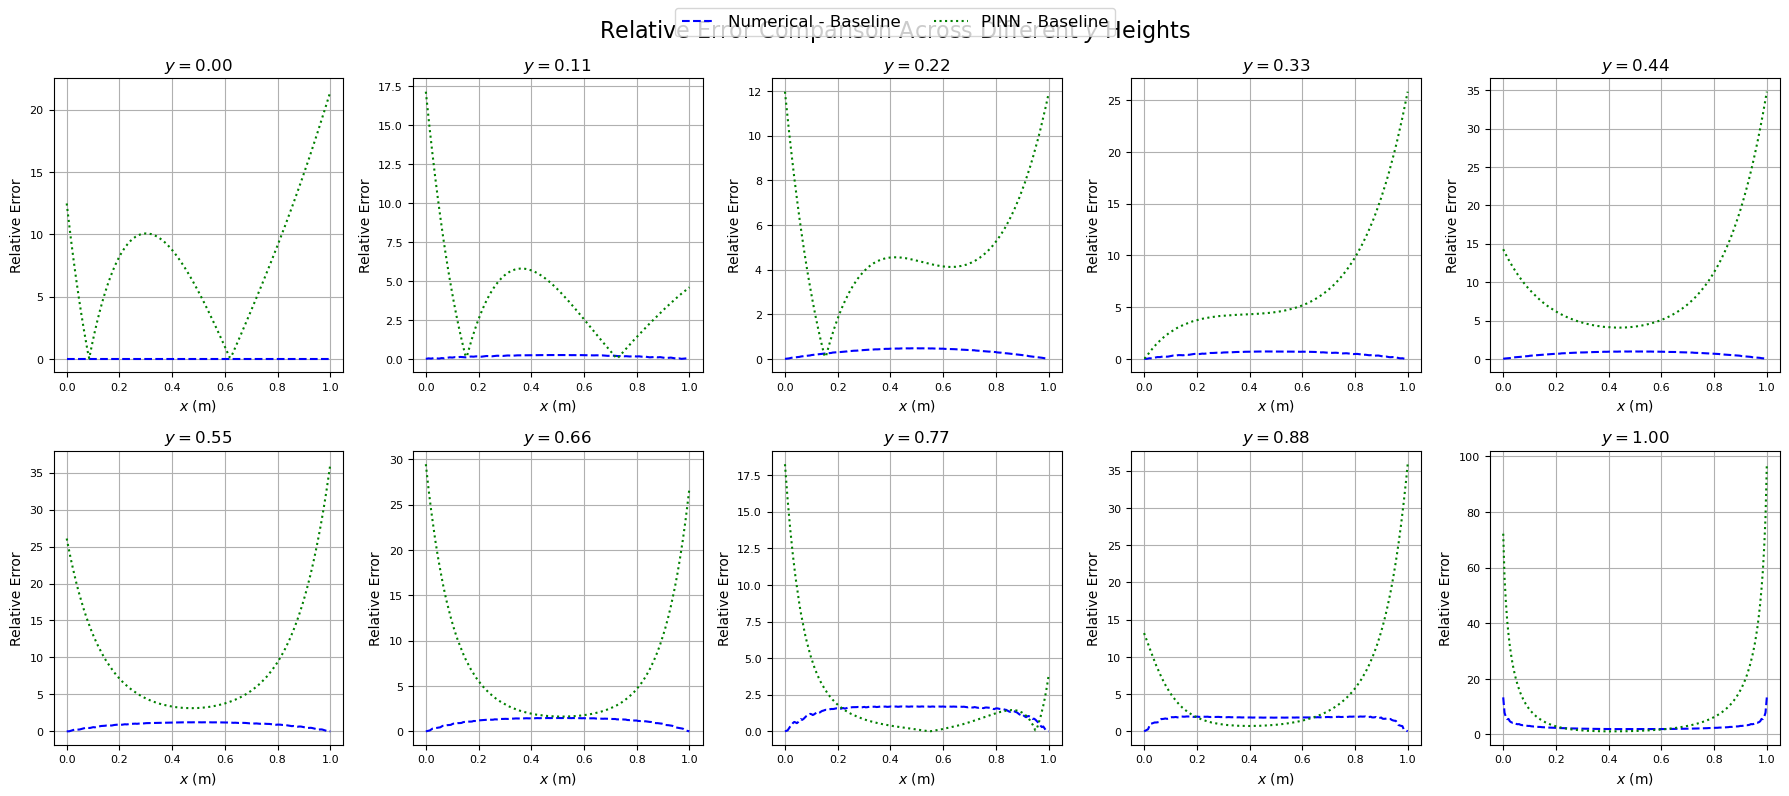

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 从 Python 文件加载数据
from data_4 import X as X_exact, Y as Y_exact, T as T_exact
from data_2 import X as X_num, Y as Y_num, T as T_num
from data_3 import X_plot as X_pinn, Y_plot as Y_pinn, T_actual as T_pinn

# 验证网格一致性，如果不一致则插值到统一网格
if not (np.array_equal(X_exact, X_num) and np.array_equal(X_exact, X_pinn)):
    print("Grid mismatch detected. Interpolating data to a common grid.")
    # 定义统一的网格
    x_common = X_exact[0, :]
    y_common = Y_exact[:, 0]
    X_common, Y_common = np.meshgrid(x_common, y_common)

    # 调试信息：检查数据形状
    print("X_num shape:", X_num.shape, "Y_num shape:", Y_num.shape, "T_num shape:", T_num.shape)
    print("X_pinn shape:", X_pinn.shape, "Y_pinn shape:", Y_pinn.shape, "T_pinn shape:", T_pinn.shape)

    # 确保形状一致
    if X_num.shape != T_num.shape or X_pinn.shape != T_pinn.shape:
        raise ValueError("Shape mismatch among data sources.")

    # 插值数值解和 PINN 解到统一网格
    try:
        T_num = griddata(
            (X_num.ravel(), Y_num.ravel()), T_num.ravel(),
            (X_common, Y_common), method='linear'
        )
        T_pinn = griddata(
            (X_pinn.ravel(), Y_pinn.ravel()), T_pinn.ravel(),
            (X_common, Y_common), method='linear'
        )
    except ValueError as e:
        print(f"Interpolation failed: {e}")
        print("Falling back to nearest-neighbor interpolation...")
        T_num = griddata(
            (X_num.ravel(), Y_num.ravel()), T_num.ravel(),
            (X_common, Y_common), method='nearest'
        )
        T_pinn = griddata(
            (X_pinn.ravel(), Y_pinn.ravel()), T_pinn.ravel(),
            (X_common, Y_common), method='nearest'
        )

# 网格定义
x = X_exact[0, :]
y = Y_exact[:, 0]
ny = len(y)
y_indices = np.linspace(0, ny - 1, 10, dtype=int)  # 选择 10 个高度切片
y_selected = y[y_indices]

# 基准选择：以解析解为基准
baseline = T_exact

# 计算相对误差
error_num = np.abs((T_num - baseline) / baseline) * 100 # 数值解与基准的相对误差
error_pinn = np.abs((T_pinn - baseline) / baseline)* 100  # PINN 与基准的相对误差

# 绘制相对误差曲线
fig, axes = plt.subplots(2, 5, figsize=(18, 8))  # 创建 2 行 5 列的子图布局

for idx, ax in enumerate(axes.flatten()):
    y_idx = y_indices[idx]  # 当前 y 索引
    # 提取当前 y 水平的误差切片
    error_num_slice = error_num[y_idx, :]
    error_pinn_slice = error_pinn[y_idx, :]

    # 绘制误差曲线
    ax.plot(x, error_num_slice, label="Numerical - Baseline", color="blue", linestyle="--")
    ax.plot(x, error_pinn_slice, label="PINN - Baseline", color="green", linestyle=":")

    # 设置标题和标签
    ax.set_title(f"$y = {y_selected[idx]:.2f}$", fontsize=12)
    ax.set_xlabel("$x$ (m)", fontsize=10)
    ax.set_ylabel("Relative Error", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True)

# 设置全局图例
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=12)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局
plt.suptitle("Relative Error Comparison Across Different $y$ Heights", fontsize=16)
plt.show()


Grid mismatch detected. Interpolating data to a common grid.
X_num shape: (51, 51) Y_num shape: (51, 51) T_num shape: (51, 51)
X_pinn shape: (100, 100) Y_pinn shape: (100, 100) T_pinn shape: (100, 100)


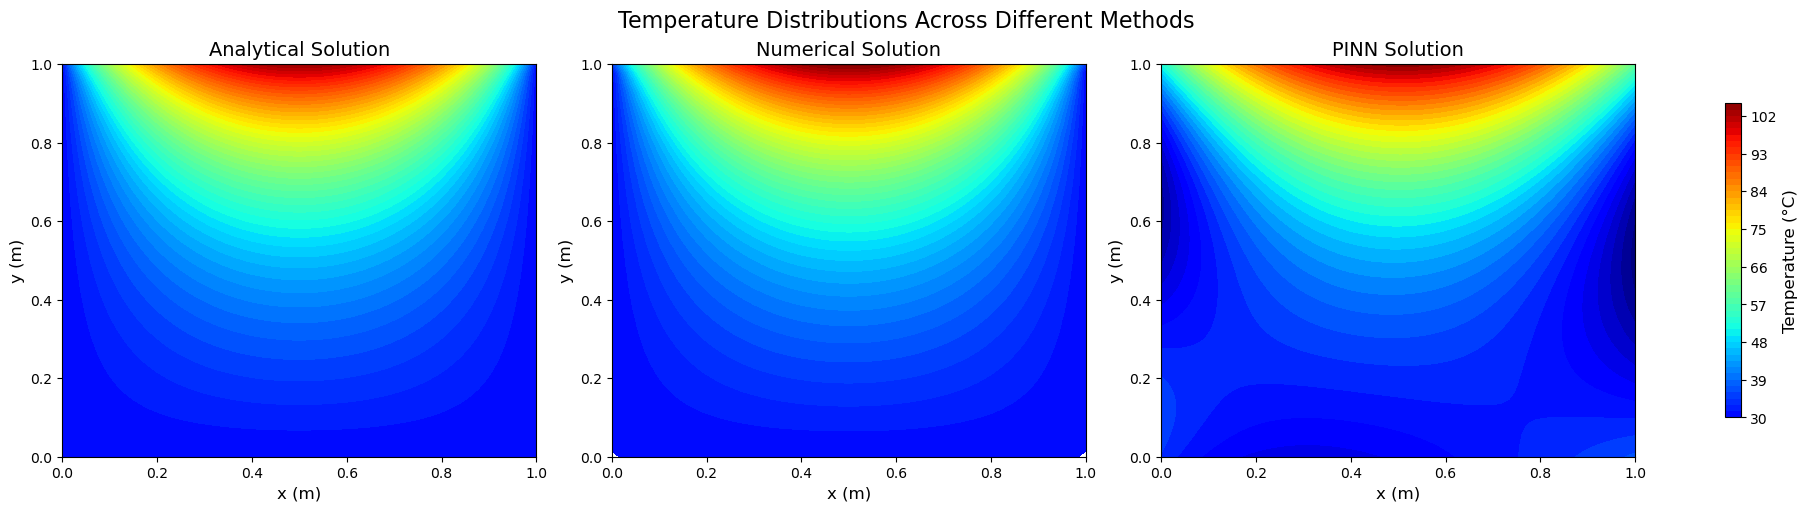

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 从 Python 文件加载数据
from data_4 import X as X_exact, Y as Y_exact, T as T_exact
from data_2 import X as X_num, Y as Y_num, T as T_num
from data_3 import X_plot as X_pinn, Y_plot as Y_pinn, T_actual as T_pinn

# 验证网格一致性，如果不一致则插值到统一网格
if not (np.array_equal(X_exact, X_num) and np.array_equal(X_exact, X_pinn)):
    print("Grid mismatch detected. Interpolating data to a common grid.")
    # 定义统一的网格
    x_common = X_exact[0, :]
    y_common = Y_exact[:, 0]
    X_common, Y_common = np.meshgrid(x_common, y_common)

    # 调试信息：检查数据形状
    print("X_num shape:", X_num.shape, "Y_num shape:", Y_num.shape, "T_num shape:", T_num.shape)
    print("X_pinn shape:", X_pinn.shape, "Y_pinn shape:", Y_pinn.shape, "T_pinn shape:", T_pinn.shape)

    # 确保形状一致
    if X_num.shape != T_num.shape or X_pinn.shape != T_pinn.shape:
        raise ValueError("Shape mismatch among data sources.")

    # 插值数值解和 PINN 解到统一网格
    try:
        T_num = griddata(
            (X_num.ravel(), Y_num.ravel()), T_num.ravel(),
            (X_common, Y_common), method='linear'
        )
        T_pinn = griddata(
            (X_pinn.ravel(), Y_pinn.ravel()), T_pinn.ravel(),
            (X_common, Y_common), method='linear'
        )
    except ValueError as e:
        print(f"Interpolation failed: {e}")
        print("Falling back to nearest-neighbor interpolation...")
        T_num = griddata(
            (X_num.ravel(), Y_num.ravel()), T_num.ravel(),
            (X_common, Y_common), method='nearest'
        )
        T_pinn = griddata(
            (X_pinn.ravel(), Y_pinn.ravel()), T_pinn.ravel(),
            (X_common, Y_common), method='nearest'
        )

# 计算所有数据的全局最小值和最大值
vmin = min(T_exact.min(), T_num.min(), T_pinn.min())
vmax = max(T_exact.max(), T_num.max(), T_pinn.max())

# 创建子图
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# 绘制解析解
c1 = axes[0].contourf(X_exact, Y_exact, T_exact, levels=50, vmin=vmin, vmax=vmax, cmap='jet')
axes[0].set_title("Analytical Solution", fontsize=14)
axes[0].set_xlabel("x (m)", fontsize=12)
axes[0].set_ylabel("y (m)", fontsize=12)

# 绘制数值解
c2 = axes[1].contourf(X_common, Y_common, T_num, levels=50, vmin=vmin, vmax=vmax, cmap='jet')
axes[1].set_title("Numerical Solution", fontsize=14)
axes[1].set_xlabel("x (m)", fontsize=12)
axes[1].set_ylabel("y (m)", fontsize=12)

# 绘制 PINN 解
c3 = axes[2].contourf(X_common, Y_common, T_pinn, levels=50, vmin=vmin, vmax=vmax, cmap='jet')
axes[2].set_title("PINN Solution", fontsize=14)
axes[2].set_xlabel("x (m)", fontsize=12)
axes[2].set_ylabel("y (m)", fontsize=12)

# 添加共享的 colorbar
cbar = fig.colorbar(c1, ax=axes, location='right', shrink=0.8)
cbar.set_label('Temperature (°C)', fontsize=12)

plt.suptitle("Temperature Distributions Across Different Methods", fontsize=16)
plt.show()


Grid mismatch detected. Interpolating data to a common grid.
X_num shape: (51, 51) Y_num shape: (51, 51) T_num shape: (51, 51)
X_pinn shape: (100, 100) Y_pinn shape: (100, 100) T_pinn shape: (100, 100)


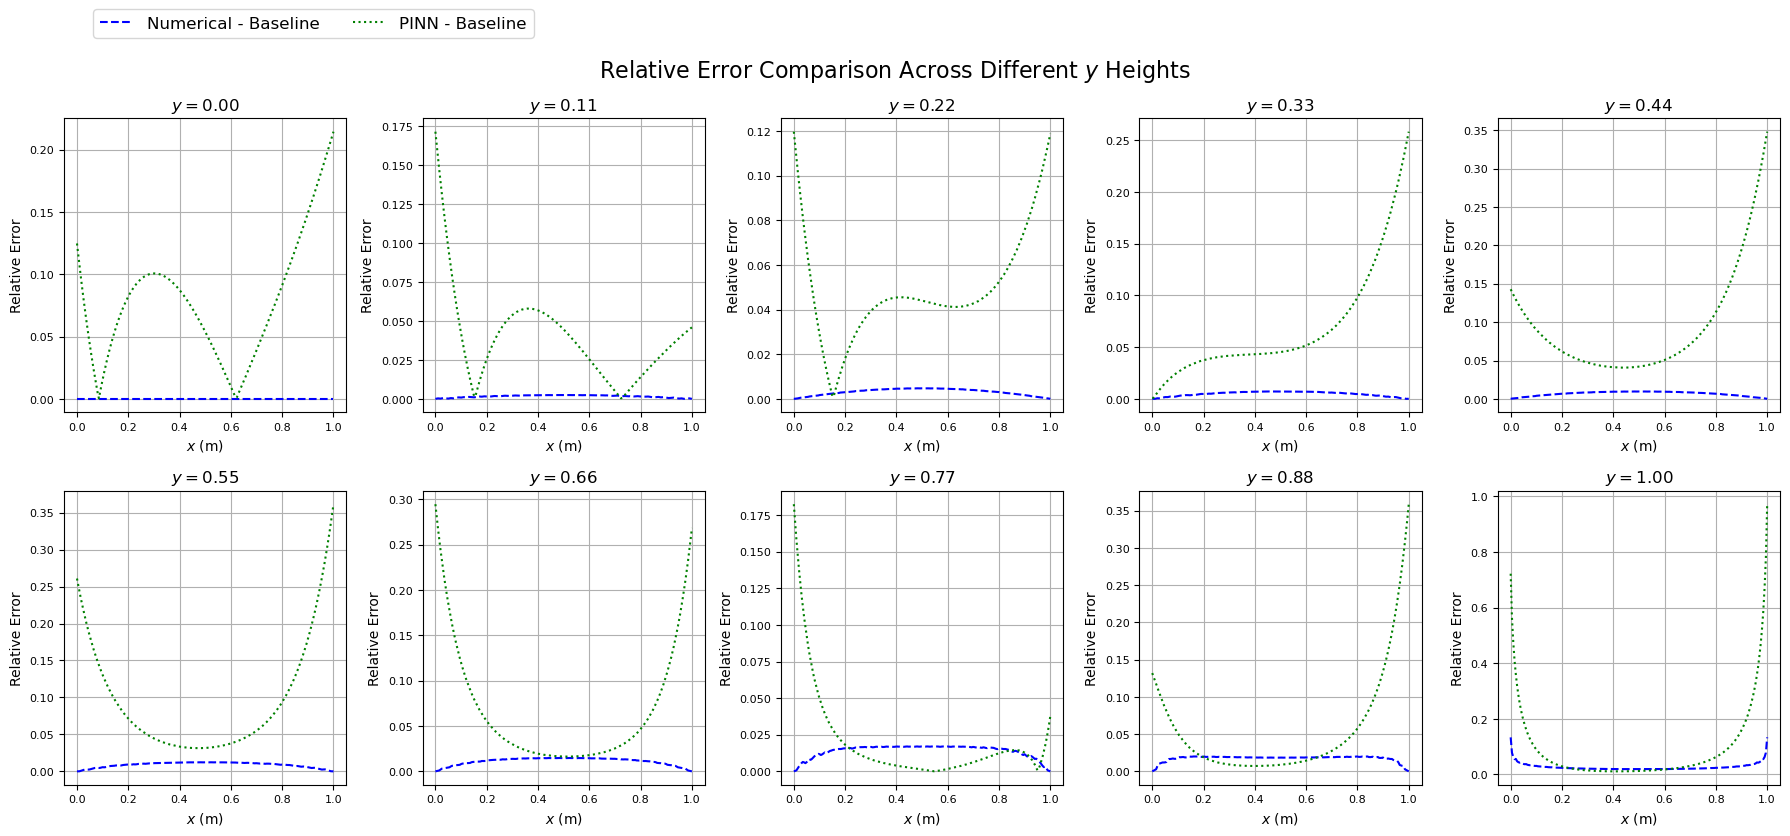

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 从 Python 文件加载数据
from data_4 import X as X_exact, Y as Y_exact, T as T_exact
from data_2 import X as X_num, Y as Y_num, T as T_num
from data_3 import X_plot as X_pinn, Y_plot as Y_pinn, T_actual as T_pinn

# 验证网格一致性，如果不一致则插值到统一网格
if not (np.array_equal(X_exact, X_num) and np.array_equal(X_exact, X_pinn)):
    print("Grid mismatch detected. Interpolating data to a common grid.")
    # 定义统一的网格
    x_common = X_exact[0, :]
    y_common = Y_exact[:, 0]
    X_common, Y_common = np.meshgrid(x_common, y_common)

    # 调试信息：检查数据形状
    print("X_num shape:", X_num.shape, "Y_num shape:", Y_num.shape, "T_num shape:", T_num.shape)
    print("X_pinn shape:", X_pinn.shape, "Y_pinn shape:", Y_pinn.shape, "T_pinn shape:", T_pinn.shape)

    # 确保形状一致
    if X_num.shape != T_num.shape or X_pinn.shape != T_pinn.shape:
        raise ValueError("Shape mismatch among data sources.")

    # 插值数值解和 PINN 解到统一网格
    try:
        T_num = griddata(
            (X_num.ravel(), Y_num.ravel()), T_num.ravel(),
            (X_common, Y_common), method='linear'
        )
        T_pinn = griddata(
            (X_pinn.ravel(), Y_pinn.ravel()), T_pinn.ravel(),
            (X_common, Y_common), method='linear'
        )
    except ValueError as e:
        print(f"Interpolation failed: {e}")
        print("Falling back to nearest-neighbor interpolation...")
        T_num = griddata(
            (X_num.ravel(), Y_num.ravel()), T_num.ravel(),
            (X_common, Y_common), method='nearest'
        )
        T_pinn = griddata(
            (X_pinn.ravel(), Y_pinn.ravel()), T_pinn.ravel(),
            (X_common, Y_common), method='nearest'
        )

# 网格定义
x = X_exact[0, :]
y = Y_exact[:, 0]
ny = len(y)
y_indices = np.linspace(0, ny - 1, 10, dtype=int)  # 选择 10 个高度切片
y_selected = y[y_indices]

# 基准选择：以解析解为基准
baseline = T_exact

# 计算相对误差
error_num = np.abs((T_num - baseline) / baseline)  # 数值解与基准的相对误差
error_pinn = np.abs((T_pinn - baseline) / baseline)  # PINN 与基准的相对误差

# 绘制相对误差曲线
fig, axes = plt.subplots(2, 5, figsize=(18, 8))  # 创建 2 行 5 列的子图布局

for idx, ax in enumerate(axes.flatten()):
    y_idx = y_indices[idx]  # 当前 y 索引
    # 提取当前 y 水平的误差切片
    error_num_slice = error_num[y_idx, :]
    error_pinn_slice = error_pinn[y_idx, :]

    # 绘制误差曲线
    ax.plot(x, error_num_slice, label="Numerical - Baseline", color="blue", linestyle="--")
    ax.plot(x, error_pinn_slice, label="PINN - Baseline", color="green", linestyle=":")

    # 设置标题和标签
    ax.set_title(f"$y = {y_selected[idx]:.2f}$", fontsize=12)
    ax.set_xlabel("$x$ (m)", fontsize=10)
    ax.set_ylabel("Relative Error", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True)

# 设置全局图例
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, 
    labels, 
    loc="upper left",  # 将图例放置在左上角
    bbox_to_anchor=(0.05, 1.05),  # 调整位置
    ncol=2, 
    fontsize=12
)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局
plt.suptitle("Relative Error Comparison Across Different $y$ Heights", fontsize=16)
plt.show()


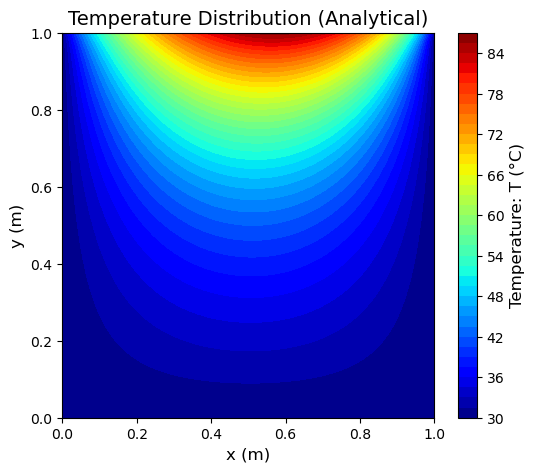

迭代次数: 3774
最大误差: 9.981350487464624e-06


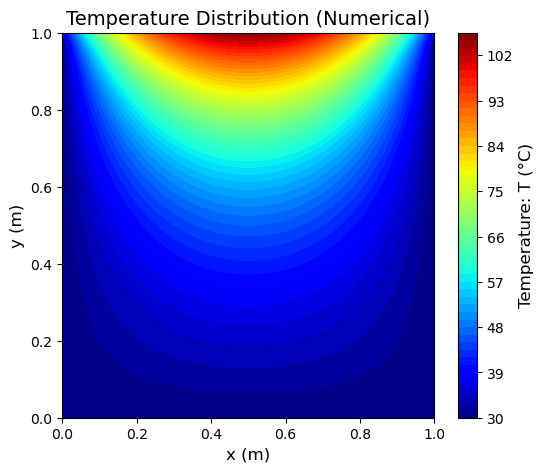

2024-12-30 13:57:09.518136: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-30 13:57:09.532973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735538229.549788 3959110 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735538229.554676 3959110 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 13:57:09.573296: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TensorFlow version: 2.18.0
Eager Execution: True


  0%|          | 2/5000 [00:00<23:51,  3.49it/s]

Epoch: 0, Loss PDE: 0.00010210393520537764, Loss BC: 1.0228010416030884


  2%|▏         | 102/5000 [00:17<13:04,  6.24it/s]

Epoch: 100, Loss PDE: 0.028155509382486343, Loss BC: 0.11382065713405609


  4%|▍         | 202/5000 [00:33<13:19,  6.00it/s]

Epoch: 200, Loss PDE: 0.01903352327644825, Loss BC: 0.030791081488132477


  6%|▌         | 302/5000 [00:49<11:21,  6.89it/s]

Epoch: 300, Loss PDE: 0.0064863828010857105, Loss BC: 0.024502770975232124


  8%|▊         | 402/5000 [01:04<11:16,  6.80it/s]

Epoch: 400, Loss PDE: 0.0020768255926668644, Loss BC: 0.02172613888978958


 10%|█         | 502/5000 [01:20<11:18,  6.63it/s]

Epoch: 500, Loss PDE: 0.002422858029603958, Loss BC: 0.03285488113760948


 12%|█▏        | 602/5000 [01:36<12:50,  5.71it/s]

Epoch: 600, Loss PDE: 0.0021422673016786575, Loss BC: 0.015347721055150032


 14%|█▍        | 702/5000 [01:52<11:26,  6.26it/s]

Epoch: 700, Loss PDE: 0.0021668903063982725, Loss BC: 0.013971497304737568


 16%|█▌        | 802/5000 [02:08<11:53,  5.88it/s]

Epoch: 800, Loss PDE: 0.002025048714131117, Loss BC: 0.018860360607504845


 18%|█▊        | 902/5000 [02:24<11:13,  6.08it/s]

Epoch: 900, Loss PDE: 0.0015706457197666168, Loss BC: 0.01140125747770071


 20%|██        | 1002/5000 [02:40<11:56,  5.58it/s]

Epoch: 1000, Loss PDE: 0.0021969908848404884, Loss BC: 0.02355170249938965


 22%|██▏       | 1102/5000 [02:56<09:50,  6.60it/s]

Epoch: 1100, Loss PDE: 0.001292186207138002, Loss BC: 0.009199315682053566


 24%|██▍       | 1202/5000 [03:12<09:52,  6.41it/s]

Epoch: 1200, Loss PDE: 0.0013542786473408341, Loss BC: 0.008611414581537247


 26%|██▌       | 1302/5000 [03:27<09:26,  6.53it/s]

Epoch: 1300, Loss PDE: 0.0013527603587135673, Loss BC: 0.008793577551841736


 28%|██▊       | 1402/5000 [03:43<09:33,  6.28it/s]

Epoch: 1400, Loss PDE: 0.0012570616090670228, Loss BC: 0.008249642327427864


 30%|███       | 1502/5000 [03:59<09:37,  6.06it/s]

Epoch: 1500, Loss PDE: 0.0012534226989373565, Loss BC: 0.00800228863954544


 32%|███▏      | 1602/5000 [04:15<09:10,  6.18it/s]

Epoch: 1600, Loss PDE: 0.0011963284341618419, Loss BC: 0.007827668450772762


 34%|███▍      | 1702/5000 [04:31<08:59,  6.11it/s]

Epoch: 1700, Loss PDE: 0.0012877266854047775, Loss BC: 0.008929431438446045


 36%|███▌      | 1802/5000 [04:47<08:22,  6.37it/s]

Epoch: 1800, Loss PDE: 0.0010972945019602776, Loss BC: 0.0076390216127038


 38%|███▊      | 1902/5000 [05:02<08:23,  6.15it/s]

Epoch: 1900, Loss PDE: 0.0010309425415471196, Loss BC: 0.007476409897208214


 40%|████      | 2002/5000 [05:18<08:30,  5.88it/s]

Epoch: 2000, Loss PDE: 0.0014397773193195462, Loss BC: 0.010984169319272041


 42%|████▏     | 2102/5000 [05:34<07:54,  6.10it/s]

Epoch: 2100, Loss PDE: 0.0008286212687380612, Loss BC: 0.007228831294924021


 44%|████▍     | 2202/5000 [05:50<07:43,  6.03it/s]

Epoch: 2200, Loss PDE: 0.0007457152823917568, Loss BC: 0.007471619173884392


 46%|████▌     | 2302/5000 [06:06<07:03,  6.36it/s]

Epoch: 2300, Loss PDE: 0.0006820398848503828, Loss BC: 0.006967208348214626


 48%|████▊     | 2402/5000 [06:22<06:31,  6.64it/s]

Epoch: 2400, Loss PDE: 0.0006506583886221051, Loss BC: 0.006748995743691921


 50%|█████     | 2502/5000 [06:38<07:05,  5.87it/s]

Epoch: 2500, Loss PDE: 0.002631824929267168, Loss BC: 0.024888135492801666


 52%|█████▏    | 2602/5000 [06:54<06:37,  6.03it/s]

Epoch: 2600, Loss PDE: 0.0006446496117860079, Loss BC: 0.006510190200060606


 54%|█████▍    | 2702/5000 [07:10<06:03,  6.33it/s]

Epoch: 2700, Loss PDE: 0.0006158363539725542, Loss BC: 0.0063555859960615635


 56%|█████▌    | 2802/5000 [07:26<05:41,  6.44it/s]

Epoch: 2800, Loss PDE: 0.0005715363076888025, Loss BC: 0.006208745762705803


 58%|█████▊    | 2902/5000 [07:42<05:28,  6.39it/s]

Epoch: 2900, Loss PDE: 0.0005507114110514522, Loss BC: 0.006138029042631388


 60%|██████    | 3001/5000 [07:58<05:42,  5.83it/s]

Epoch: 3000, Loss PDE: 0.0005038692615926266, Loss BC: 0.005851738154888153


 62%|██████▏   | 3102/5000 [08:15<05:04,  6.23it/s]

Epoch: 3100, Loss PDE: 0.0004997305804863572, Loss BC: 0.005605734884738922


 64%|██████▍   | 3201/5000 [08:31<05:03,  5.92it/s]

Epoch: 3200, Loss PDE: 0.0005297979223541915, Loss BC: 0.005540364887565374


 66%|██████▌   | 3302/5000 [08:47<04:25,  6.39it/s]

Epoch: 3300, Loss PDE: 0.0005481485277414322, Loss BC: 0.0052954223938286304


 68%|██████▊   | 3402/5000 [09:03<04:31,  5.88it/s]

Epoch: 3400, Loss PDE: 0.0005505570443347096, Loss BC: 0.005132260732352734


 70%|███████   | 3502/5000 [09:20<04:00,  6.22it/s]

Epoch: 3500, Loss PDE: 0.0005472893826663494, Loss BC: 0.005028279032558203


 72%|███████▏  | 3602/5000 [09:36<03:48,  6.11it/s]

Epoch: 3600, Loss PDE: 0.0005678635207004845, Loss BC: 0.004895402118563652


 74%|███████▍  | 3702/5000 [09:52<03:36,  6.00it/s]

Epoch: 3700, Loss PDE: 0.0005507269524969161, Loss BC: 0.004750336054712534


 76%|███████▌  | 3802/5000 [10:08<02:58,  6.72it/s]

Epoch: 3800, Loss PDE: 0.0005783196538686752, Loss BC: 0.0045824297703802586


 78%|███████▊  | 3902/5000 [10:24<03:01,  6.05it/s]

Epoch: 3900, Loss PDE: 0.0018052111845463514, Loss BC: 0.01363905519247055


 80%|████████  | 4002/5000 [10:40<02:33,  6.52it/s]

Epoch: 4000, Loss PDE: 0.0005770734278485179, Loss BC: 0.0043958560563623905


 82%|████████▏ | 4102/5000 [10:56<02:19,  6.44it/s]

Epoch: 4100, Loss PDE: 0.0005802494124509394, Loss BC: 0.0042624822817742825


 84%|████████▍ | 4202/5000 [11:12<02:01,  6.55it/s]

Epoch: 4200, Loss PDE: 0.0005537451361306012, Loss BC: 0.004210371058434248


 86%|████████▌ | 4302/5000 [11:28<01:51,  6.28it/s]

Epoch: 4300, Loss PDE: 0.0005549801280722022, Loss BC: 0.004058895632624626


 88%|████████▊ | 4402/5000 [11:44<01:33,  6.41it/s]

Epoch: 4400, Loss PDE: 0.0009175246814265847, Loss BC: 0.0048169419169425964


 90%|█████████ | 4502/5000 [12:00<01:21,  6.12it/s]

Epoch: 4500, Loss PDE: 0.0005426573334261775, Loss BC: 0.003868939820677042


 92%|█████████▏| 4602/5000 [12:17<01:06,  6.01it/s]

Epoch: 4600, Loss PDE: 0.0005437980871647596, Loss BC: 0.003710248740389943


 94%|█████████▍| 4702/5000 [12:34<00:51,  5.77it/s]

Epoch: 4700, Loss PDE: 0.0005598787101916969, Loss BC: 0.003835108131170273


 96%|█████████▌| 4802/5000 [12:51<00:31,  6.38it/s]

Epoch: 4800, Loss PDE: 0.000565096503123641, Loss BC: 0.003492288291454315


 98%|█████████▊| 4902/5000 [13:07<00:16,  5.97it/s]

Epoch: 4900, Loss PDE: 0.0006831653881818056, Loss BC: 0.00408907700330019


100%|██████████| 5000/5000 [13:23<00:00,  6.23it/s]


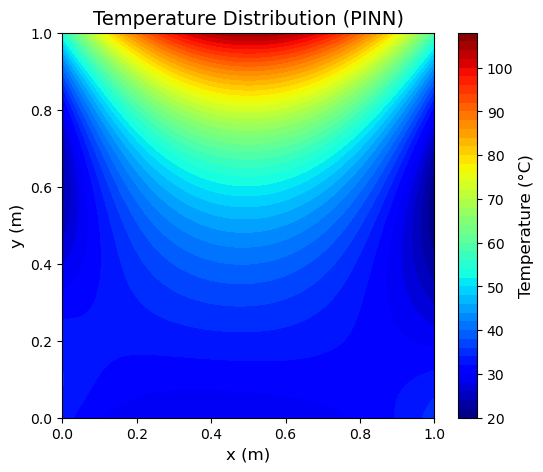

Grid mismatch detected. Interpolating data to a common grid.
X_num shape: (51, 51) Y_num shape: (51, 51) T_num shape: (51, 51)
X_pinn shape: (100, 100) Y_pinn shape: (100, 100) T_pinn shape: (100, 100)


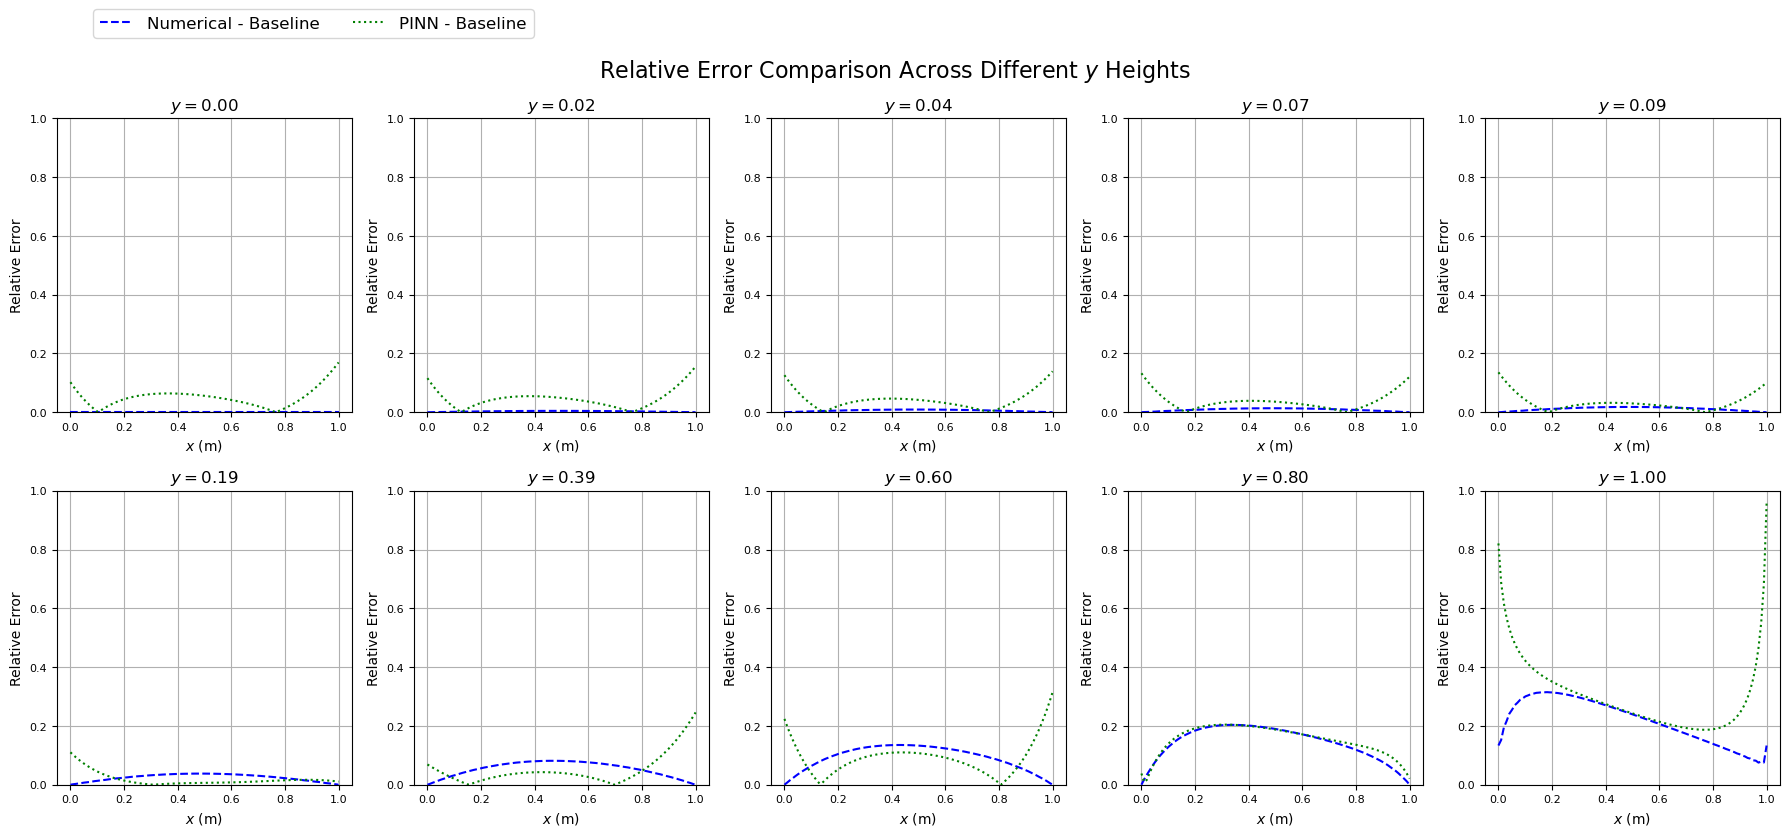

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 从 Python 文件加载数据
from data_1 import X as X_exact, Y as Y_exact, T as T_exact
from data_2 import X as X_num, Y as Y_num, T as T_num
from data_3 import X_plot as X_pinn, Y_plot as Y_pinn, T_actual as T_pinn

# 验证网格一致性，如果不一致则插值到统一网格
if not (np.array_equal(X_exact, X_num) and np.array_equal(X_exact, X_pinn)):
    print("Grid mismatch detected. Interpolating data to a common grid.")
    # 定义统一的网格
    x_common = X_exact[0, :]
    y_common = Y_exact[:, 0]
    X_common, Y_common = np.meshgrid(x_common, y_common)

    # 调试信息：检查数据形状
    print("X_num shape:", X_num.shape, "Y_num shape:", Y_num.shape, "T_num shape:", T_num.shape)
    print("X_pinn shape:", X_pinn.shape, "Y_pinn shape:", Y_pinn.shape, "T_pinn shape:", T_pinn.shape)

    # 确保形状一致
    if X_num.shape != T_num.shape or X_pinn.shape != T_pinn.shape:
        raise ValueError("Shape mismatch among data sources.")

    # 插值数值解和 PINN 解到统一网格
    try:
        T_num = griddata(
            (X_num.ravel(), Y_num.ravel()), T_num.ravel(),
            (X_common, Y_common), method='linear'
        )
        T_pinn = griddata(
            (X_pinn.ravel(), Y_pinn.ravel()), T_pinn.ravel(),
            (X_common, Y_common), method='linear'
        )
    except ValueError as e:
        print(f"Interpolation failed: {e}")
        print("Falling back to nearest-neighbor interpolation...")
        T_num = griddata(
            (X_num.ravel(), Y_num.ravel()), T_num.ravel(),
            (X_common, Y_common), method='nearest'
        )
        T_pinn = griddata(
            (X_pinn.ravel(), Y_pinn.ravel()), T_pinn.ravel(),
            (X_common, Y_common), method='nearest'
        )

# 网格定义
x = X_exact[0, :]
y = Y_exact[:, 0]
ny = len(y)
y_indices = np.linspace(0, ny - 1, 10, dtype=int)  # 选择 10 个高度切片
y_selected = y[y_indices]

# 基准选择：以解析解为基准
baseline = T_exact

# 计算相对误差
error_num = np.abs((T_num - baseline) / baseline)  # 数值解与基准的相对误差
error_pinn = np.abs((T_pinn - baseline) / baseline)  # PINN 与基准的相对误差

# 绘制相对误差曲线
fig, axes = plt.subplots(2, 5, figsize=(18, 8))  # 创建 2 行 5 列的子图布局

for idx, ax in enumerate(axes.flatten()):
    y_idx = y_indices[idx]  # 当前 y 索引
    # 提取当前 y 水平的误差切片
    error_num_slice = error_num[y_idx, :]
    error_pinn_slice = error_pinn[y_idx, :]

    # 绘制误差曲线
    ax.plot(x, error_num_slice, label="Numerical - Baseline", color="blue", linestyle="--")
    ax.plot(x, error_pinn_slice, label="PINN - Baseline", color="green", linestyle=":")

    # 设置标题和标签
    ax.set_title(f"$y = {y_selected[idx]:.2f}$", fontsize=12)
    ax.set_xlabel("$x$ (m)", fontsize=10)
    ax.set_ylabel("Relative Error", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True)
    ax.set_ylim(0, 1)  # 设置纵轴范围为 [0, 1]

# 设置全局图例
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, 
    labels, 
    loc="upper left",  # 将图例放置在左上角
    bbox_to_anchor=(0.05, 1.05),  # 调整位置
    ncol=2, 
    fontsize=12
)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局
plt.suptitle("Relative Error Comparison Across Different $y$ Heights", fontsize=16)
plt.show()
